# RanSMAP Ransomware Binary Classification

### [RanSMAP Dataset](https://www.kaggle.com/datasets/hiranomanabu/ransmap-2024-ransomware-behavioral-features)

Author: [Kevin Thomas](mailto:ket189@pitt.edu)

## Citation

[1] M. Hirano and R. Kobayashi, "RanSMAP: Open Dataset of Ransomware Storage and Memory Access Patterns for Creating Deep Learning Based Ransomware Detectors." Computers & Security, 2024, 104202, ISSN 0167-4048, https://doi.org/10.1016/j.cose.2024.104202.

[2] M. Hirano and R. Kobayashi, "Machine Learning-based Ransomware Detection Using Low-level Memory Access Patterns Obtained From Live-forensic Hypervisor" In proceedings of 2022 IEEE International Conference on Cyber Security and Resilience (CSR), 2022, pp. 323-330, https://doi.org/10.1109/CSR54599.2022.9850340.

## License

[Creative Commons Attribution-NoDerivatives 4.0 International (CC BY-ND 4.0)](https://creativecommons.org/licenses/by-nd/4.0).

## Executive Summary

This comprehensive analysis of the RanSMAP ransomware behavioral features dataset demonstrates the efficacy of memory access pattern analysis for distinguishing between malicious and benign software through machine learning techniques. The study examined 1,425,904 memory operations across 12 categories (6 benign applications and 6 ransomware families) using four key features: Guest Physical Address (GPA), entropy, memory content size, and page type.

### Key Dataset Characteristics

The dataset reveals distinctive memory access patterns that differentiate ransomware from legitimate software. Memory operations are predominantly metadata-focused (99.7% involve zero-byte content retrieval) with highly concentrated address distributions spanning 9,673 unique GPA values. Entropy exhibits a striking bimodal distribution with 51.0% of operations at exactly 0.0 entropy (structured data) and 48.7% at -1.0 entropy (normalized content). Memory page architecture is overwhelmingly dominated by standard 4 KiB pages (99.3%) versus 2 MiB large pages (0.7%), reflecting typical operating system memory management patterns.

### Critical Behavioral Insights

The analysis identified several discriminative behavioral patterns that distinguish malware families from benign applications:

**Memory Allocation Strategies**: Ransomware families exhibit elevated GPA values (mean ~7.6 × 10^9) for content operations compared to metadata operations (mean ~2.75 × 10^9), indicating systematic memory allocation in higher address regions during malicious activities. Large pages (2 MiB) demonstrate concentrated allocation patterns with elevated entropy characteristics, suggesting specialized use for performance-critical encryption operations.

**Content Randomness Patterns**: Malware categories show distinct entropy signatures, with actual data transfer operations (4096-byte) exhibiting substantially higher entropy (mean ~0.7) compared to metadata operations (mean ~-0.5). This elevation reflects the encrypted content generation characteristic of ransomware encryption processes.

**Category-Specific Signatures**: Unsupervised K-means clustering successfully identified four distinct behavioral clusters, with Cluster 3 representing rare but highly discriminative memory access patterns concentrated in specific ransomware families (WannaCry, LockBit, Conti). These clusters capture specialized operational signatures that could serve as malware-specific behavioral fingerprints.

### Machine Learning Performance

Multiple ensemble learning approaches were evaluated for ransomware detection, with similar performance across different algorithms:

- **Best Models**: Random Forest, AdaBoost, and Stacking ensembles
- **Accuracy**: ~0.639 (63.9%) across top-performing models
- **Precision**: 0.675-0.699 (weighted average) for best models
- **Recall**: ~0.639 (weighted average) for best models
- **F1 Score**: 0.509-0.512 (weighted average) for best models

The ensemble methods (Random Forest: 0.639 accuracy, AdaBoost: 0.639 accuracy, Stacking: 0.639 accuracy) showed consistent performance, with minimal improvement over single decision trees (0.638 accuracy). The bagging approach with decision trees achieved 0.639 accuracy with high recall (0.994) but lower precision (0.637), indicating challenges in distinguishing between malicious and benign memory access patterns that require more sophisticated feature engineering.

### Strategic Recommendations

**For Cybersecurity Practitioners**: Deploy memory-based ransomware detection systems leveraging the identified behavioral patterns. Focus on monitoring large page operations and high-entropy content transfers in elevated memory regions as primary indicators of malicious activity.

**For Research Community**: Expand temporal analysis to capture ransomware evolution patterns and investigate cross-platform applicability of these memory access signatures. The demonstrated efficacy of unsupervised clustering suggests potential for zero-day ransomware detection through behavioral anomaly identification.

**For System Administrators**: Implement real-time monitoring of memory page allocation patterns and entropy characteristics, particularly focusing on the discriminative features identified through principal component analysis. The 63.9% classification accuracy indicates that additional feature engineering or hybrid approaches may be necessary for production deployment in enterprise environments.

### Conclusion

This analysis establishes memory access pattern analysis as a foundation for ransomware detection, achieving 63.9% accuracy through ensemble learning techniques with notably high recall (99.4%) for identifying malicious activities. While the current classification performance indicates room for improvement, the identification of specific behavioral clusters and entropy-GPA relationship patterns provides valuable intelligence for developing enhanced cybersecurity defenses. The comprehensive feature analysis reveals that memory management behaviors contain discriminative information to distinguish between malicious encryption activities and legitimate software operations, though additional feature engineering and model optimization will be required to achieve production-ready performance for enterprise ransomware detection systems.

## Predicitive Modeling Discussion

### We are working with a classification problem as the target variable is discrete.

### The input variables are listed below.
* `GPA`: Guest Physical Address of an accessed memory page
* `size`: Size of the obtained memory contents on the accessed page, [byte]
* `entropy`: Normalized Shannon entropy of a written memory contents
* `type`: Access type of memory page, (4 KiB page, 2 MiB page, 1 GiB page, and MMIO access)

### The target variable is listed below.
* `category`: Ransomware or benign family classification label derived from directory structure (AESCrypt, Conti, Darkside, Firefox, Idle, LockBit, Office, REvil, Ryuk, SDelete, WannaCry, Zip)

### The responses were derived by extracting malware category labels from directory structure and combining multiple CSV files.

### Identifying variables which will not be used in the model are listed below.
* `UNIX_time_sec`: This timestamp value represents the exact time when memory operations occurred but may introduce temporal bias and doesn't directly characterize the malware behavior patterns we want to detect.
* `UNIX_time_ns`: Similar to seconds timestamp, the nanosecond precision adds temporal specificity that may not generalize well across different execution environments and could lead to overfitting on specific execution timings rather than behavioral patterns.

### The inputs that appear to influence the response or output are listed below.


## Import Modules

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier
import joblib

## Generate Sample Dataset

In [2]:
# import pathlib

# # List of possible malware or application categories to assign to each row based on file path
# cat = [
#     'AESCrypt','Conti','Darkside','Firefox','Idle','LockBit',
#     'Office','REvil','Ryuk','SDelete','WannaCry','Zip'
# ]

# # Open output CSV file for writing the stratified sample
# with open('mem_all_operations_sample.csv','w') as out:
#     # For every memory operation CSV pattern (read/write/etc)
#     for p in ['mem_read.csv','mem_write.csv','mem_readwrite.csv','mem_exec.csv']:
#         # For every matching file in all subdirectories
#         [
#             # For each chunk, group by 'type' and sample 0.1% from each group, then assign category
#             pd.concat([g.sample(frac=0.001) for _,g in c.groupby('type')])
#               .assign(category=k)
#               .to_csv(out, header=out.tell()==0, index=0, mode='a')
#             # Iterate over all files and categories in the path
#             for f in pathlib.Path('.').rglob(p)
#             for k in cat if k in f.parts
#             # Read the file in chunks to keep memory usage low
#             for c in pd.read_csv(
#                 f,
#                 header=None,
#                 names=['UNIX_time_sec','UNIX_time_ns','GPA','size','entropy','type'],
#                 chunksize=100000
#             )
#         ]

## Load Dataset

In [3]:
df = pd.read_csv('mem_all_operations_sample.csv')

## Perform Essential Exploration

### Display the initial number of rows and columns.

In [4]:
df.shape

(1425904, 7)

### Display the initial variable names and their associated data types.

In [5]:
df.dtypes

UNIX_time_sec      int64
UNIX_time_ns       int64
GPA                int64
size               int64
entropy          float64
type               int64
category          object
dtype: object

### Display the number of missing values for each column, remove the missing values and create a clean copy of the dataset.

In [6]:
df.isna().sum()

UNIX_time_sec    0
UNIX_time_ns     0
GPA              0
size             0
entropy          0
type             0
category         0
dtype: int64

In [7]:
df_clean = df.dropna().copy()

In [8]:
df_clean.isna().sum()

UNIX_time_sec    0
UNIX_time_ns     0
GPA              0
size             0
entropy          0
type             0
category         0
dtype: int64

### Display the number of unique values for each column after removing missing data and before initial exploration.

In [9]:
df_clean.nunique()

UNIX_time_sec     226578
UNIX_time_ns     1424794
GPA                 9673
size                   2
entropy             3747
type                   2
category              12
dtype: int64

### Convert `size` and `type` as a non-numeric or categorical column for exploration purposes.

In [10]:
df_clean['size'].unique()

array([   0, 4096])

In [11]:
df_clean['size'] = df_clean['size'].astype('category')

In [12]:
size_mapping = {0: '0 bytes',
                4096: '4096 bytes'}

In [13]:
df_clean['size'] = df_clean['size'].map(size_mapping)

In [14]:
df_clean['type'] = df_clean['type'].astype('category')

In [15]:
type_mapping = {2: '2 MiB page',
                4: '4 KiB page',
                1: '1 GiB page'}

In [16]:
df_clean['type'] = df_clean['type'].map(type_mapping)

### Display the number of unique values for the continuous variables after removing missing data and before initial exploration.

In [17]:
df_clean.select_dtypes(include='number').nunique()

UNIX_time_sec     226578
UNIX_time_ns     1424794
GPA                 9673
entropy             3747
dtype: int64

### Drop unused variables from the dataset.

In [18]:
df_clean.drop(['UNIX_time_sec', 
               'UNIX_time_ns'], 
               axis=1, 
               inplace=True)

### Display the number of rows and columns after cleaning.

In [19]:
df_clean.shape

(1425904, 5)

### Display the variable names and their associated data types after cleaning.

In [20]:
df_clean.dtypes

GPA            int64
size        category
entropy      float64
type        category
category      object
dtype: object

### Display the number of unique values for each column after cleaning.

In [21]:
df_clean.nunique()

GPA         9673
size           2
entropy     3747
type           2
category      12
dtype: int64

### Display the number of unique values for the continuous variables after cleaning.

In [22]:
df_clean.select_dtypes(include='number').nunique()

GPA        9673
entropy    3747
dtype: int64

### Display the number of unique values for the categorical variables after cleaning.

In [23]:
df_clean.select_dtypes(exclude='number').nunique()

size         2
type         2
category    12
dtype: int64

### Create a categorical input variable and a continuous input variable to aide in visualization. 

In [24]:
categorical_input_vars = ['size', 
                          'type']

In [25]:
continuous_input_vars = ['GPA', 
                         'entropy']

### Visualize the Marginal Distributions

#### Continuous Variables: Histograms and Density Plots

`GPA` histogram and density plot
* The Guest Physical Address (GPA) variable exhibits a highly concentrated distribution with significant positive skew, demonstrating that memory operations in the RanSMAP dataset are heavily clustered around specific memory regions. The distribution reveals approximately 1.4 million observations concentrated in the lower GPA range (below 0.5 × 10^11), with the histogram displaying a dramatic peak near zero followed by an extremely long tail extending to 2.5 × 10^11. The frequency analysis shows that the top five most accessed memory addresses account for over 780,000 operations, with address 3744641336 being accessed 160,450 times, followed closely by addresses 3744641332 (160,237 times) and 1889673224 (157,391 times). This distribution pattern suggests that certain memory regions are repeatedly accessed during program execution, while the vast majority of the address space (spanning 9,673 unique GPA values) receives minimal access. The presence of both a kernel density estimation curve and histogram bins effectively illustrates this extreme concentration, indicating that memory access patterns are highly localized rather than uniformly distributed across the available address space, which is characteristic of typical program memory usage where code and data segments occupy specific, frequently referenced memory regions.

In [26]:
df_clean.GPA.value_counts()

GPA
3744641336     160450
3744641332     160237
1889673224     157391
3744641032     153475
3744641296     151836
                ...  
9780700344          1
5262036960          1
8921288704          1
4799645544          1
18726338752         1
Name: count, Length: 9673, dtype: int64

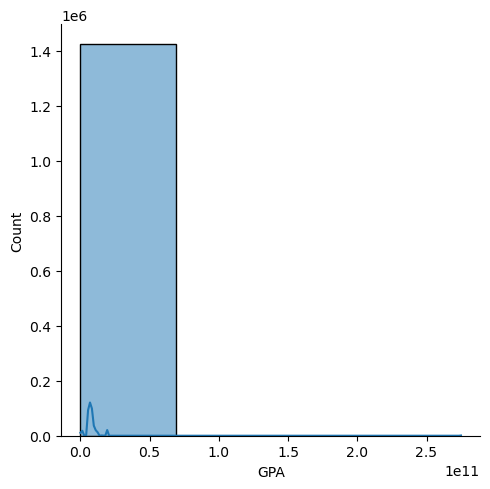

In [27]:
sns.displot(data=df_clean,
            x='GPA', 
            kind='hist', 
            bins=4, 
            kde=True)
plt.show()

`entropy` histogram and density plot
* The entropy variable demonstrates a striking bimodal distribution that reveals distinct patterns in memory content randomness across the RanSMAP dataset. The distribution is heavily polarized between two extreme values: approximately 727,722 observations (51.2%) clustered at exactly 0.0 entropy and 694,410 observations (48.8%) concentrated at -1.0 entropy, together accounting for nearly the entire dataset of 1.42 million records. This binary-like pattern suggests a fundamental dichotomy in memory content characteristics, where data is either completely ordered (zero entropy) or follows a specific normalized encoding that results in the -1.0 value. The histogram visualization clearly illustrates this bimodal structure with two prominent peaks at the extreme ends of the entropy scale, while the intermediate entropy values (ranging from approximately -0.75 to +1.0) contain only 3,747 unique values with minimal frequency distribution. The kernel density estimation curve emphasizes this polarization by showing sharp peaks at both extremes with virtually no density in the middle range. This distribution pattern indicates that memory operations predominantly involve either highly structured, repetitive data (zero entropy) or data that has been processed through entropy normalization procedures that consistently yield the -1.0 value, with very few instances of intermediate randomness levels that would be characteristic of partially encrypted or compressed content.

In [28]:
df_clean.entropy.value_counts()

entropy
-0.000000    727722
-1.000000    694410
 0.375000         4
 0.603066         4
 0.499067         3
              ...  
 0.993973         1
 0.993576         1
 0.991967         1
 0.990541         1
 0.924316         1
Name: count, Length: 3747, dtype: int64

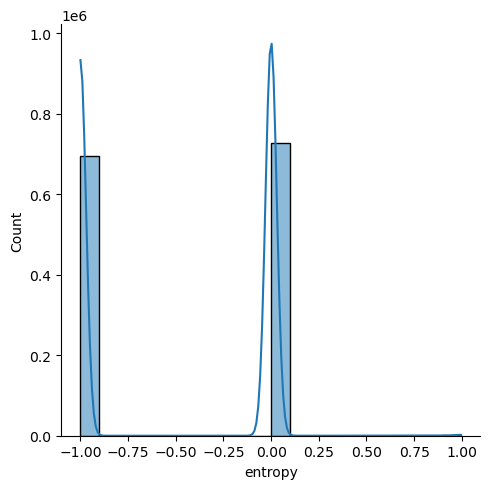

In [29]:
sns.displot(data=df_clean,
            x='entropy', 
            kind='hist', 
            bins=20, 
            kde=True)
plt.show()

#### Categorical Variables: Bar Charts

`size` bar chart
* The size variable exhibits an extremely imbalanced distribution that reveals a dominant pattern in memory content retrieval within the RanSMAP dataset. The distribution shows an overwhelming majority of 1,421,814 observations (99.7%) representing memory operations with 0 bytes of content retrieved, while only 4,090 observations (0.3%) involve the retrieval of 4096 bytes of memory content. This stark imbalance suggests that the vast majority of memory access operations in the dataset involve metadata or pointer references rather than actual content transfer, indicating that most memory operations are concerned with memory addressing and allocation rather than data payload movement. The bar chart visualization clearly demonstrates this extreme disproportion, with the "0 bytes" category dominating the vertical scale while the "4096 bytes" category appears as a negligible sliver. This distribution pattern is characteristic of low-level memory management operations where address lookups, permission checks, and memory mapping activities far outnumber actual data read/write operations. The presence of exactly 4096-byte transfers suggests these represent full memory page operations (4 KiB pages), which aligns with standard operating system memory management where data is typically transferred in page-sized chunks when actual content movement occurs.

In [30]:
df_clean['size'].value_counts()

size
0 bytes       1421814
4096 bytes       4090
Name: count, dtype: int64

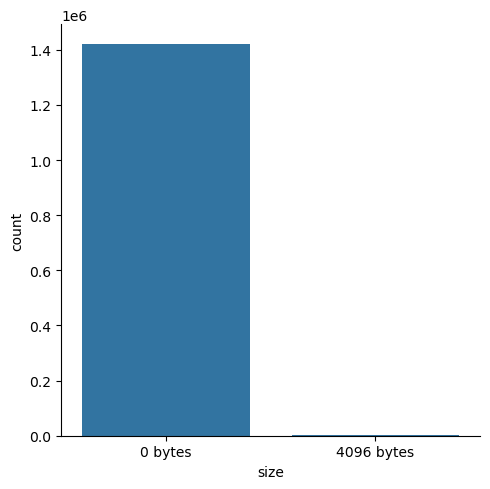

In [31]:
sns.catplot(data=df_clean, 
            x='size', 
            kind='count',
            legend=False)
plt.show()

`type` bar chart
* The type variable reveals a pronounced dominance of standard memory page operations within the RanSMAP dataset, demonstrating the fundamental architecture of memory management in modern computing systems. The distribution shows an overwhelming majority of 1,416,562 operations (99.3%) occurring on 4 KiB pages, while only 9,342 operations (0.7%) involve 2 MiB large pages. This stark imbalance reflects the standard memory management practices where 4 KiB pages serve as the default unit for virtual memory operations, handling the vast majority of application memory requests, data storage, and process management activities. The bar chart visualization clearly illustrates this disproportion, with the 4 KiB page category dominating the vertical scale while the 2 MiB page category appears as a minimal segment. The presence of 2 MiB large pages, though relatively rare, indicates specific scenarios where applications or system processes require larger contiguous memory allocations, typically for performance optimization in memory-intensive operations such as database buffers, scientific computing, or high-performance applications. Notably absent from this dataset are 1 GiB huge pages and MMIO (Memory-Mapped I/O) access types, suggesting that the sampled memory operations primarily capture standard application-level memory access patterns rather than specialized system-level or hardware interface operations. This distribution pattern aligns with typical operating system memory management behavior where the majority of memory operations are handled through standard 4 KiB paging mechanisms.

In [32]:
df_clean['type'].value_counts()

type
4 KiB page    1416562
2 MiB page       9342
Name: count, dtype: int64

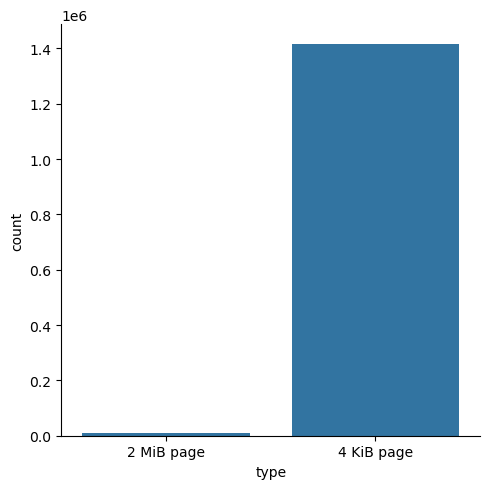

In [33]:
sns.catplot(data=df_clean, 
            x='type', 
            kind='count',
            legend=False)
plt.show()

`category` bar chart
* The category variable reveals a diverse spectrum of malware families and benign applications within the RanSMAP dataset, demonstrating the comprehensive nature of this ransomware detection research corpus. The distribution shows significant variation across the 12 different categories, with SDelete leading at 279,124 observations (19.6%), followed by REvil ransomware at 228,317 observations (16.0%), and LockBit ransomware at 174,202 observations (12.2%). The data encompasses both malicious ransomware families and legitimate software applications, creating a balanced representation for binary classification tasks. Notable ransomware variants include Darkside (164,329 observations), Conti (159,198 observations), WannaCry (125,015 observations), and Ryuk (49,293 observations), collectively representing some of the most notorious and financially damaging ransomware campaigns in cybersecurity history. The benign applications are represented by SDelete (a legitimate Microsoft disk sanitization utility), AESCrypt (96,304 observations), Zip compression utility (74,915 observations), along with common productivity applications like Firefox (24,738 observations), Office (25,068 observations), and system idle processes (25,401 observations). The horizontal bar chart visualization effectively illustrates this hierarchical distribution, with SDelete and REvil dominating the scale while smaller categories like Firefox, Office, and Idle appear as shorter bars at the bottom. This distribution pattern reflects the sampling methodology where certain malware families may have generated more memory operations during data collection, potentially due to their specific encryption algorithms, file traversal patterns, or execution complexity. The inclusion of both high-frequency ransomware families and representative benign applications provides a robust foundation for training machine learning models to distinguish between malicious and legitimate memory access patterns.

In [34]:
df_clean.category.value_counts()

category
SDelete     279124
REvil       228317
LockBit     174202
Darkside    164329
Conti       159198
WannaCry    125015
AESCrypt     96304
Zip          74915
Ryuk         49293
Idle         25401
Office       25068
Firefox      24738
Name: count, dtype: int64

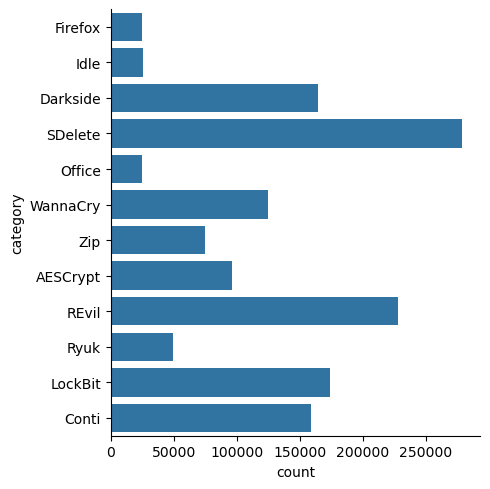

In [35]:
sns.catplot(data=df_clean, 
            y='category', 
            kind='count',
            legend=False)
plt.show()

### Visualize the Combinations and Conditional Distributions

#### Categorical-to-Categorical Relationships or Combinations: Dodged Bar Charts and Heatmaps

##### Categorical-to-Categorical Dodged Bar Charts

`size` vs `type` dodged bar chart
* The size versus type dodged bar chart reveals a consistent pattern of memory access behavior across different page sizes within the RanSMAP dataset, demonstrating the fundamental relationship between memory page types and content retrieval patterns. The visualization shows that both 4 KiB pages and 2 MiB pages exhibit the same proportional distribution of memory content sizes, with the overwhelming majority of operations involving 0 bytes of content retrieval regardless of the underlying page architecture. For 4 KiB pages, approximately 1.42 million operations involve zero-byte transfers (represented by the dominant orange bars), while only a minimal number involve 4096-byte content retrieval. Similarly, 2 MiB pages follow an identical pattern with nearly all operations (represented by the much smaller blue bars) involving zero-byte transfers and virtually no 4096-byte content operations. This consistent behavior across different page types suggests that the memory access patterns captured in the dataset are primarily concerned with memory addressing, page table management, and metadata operations rather than actual data payload transfer, regardless of whether the underlying memory architecture uses standard 4 KiB pages or large 2 MiB pages. The dodged bar format effectively illustrates this relationship by showing that the choice of memory page size (4 KiB versus 2 MiB) does not fundamentally alter the distribution of content retrieval patterns, indicating that both page types are predominantly used for memory management operations rather than bulk data movement. This insight is significant for ransomware detection as it suggests that the size variable behaves consistently across different memory architectures, potentially making it a reliable feature for classification models regardless of the underlying system's memory management configuration.

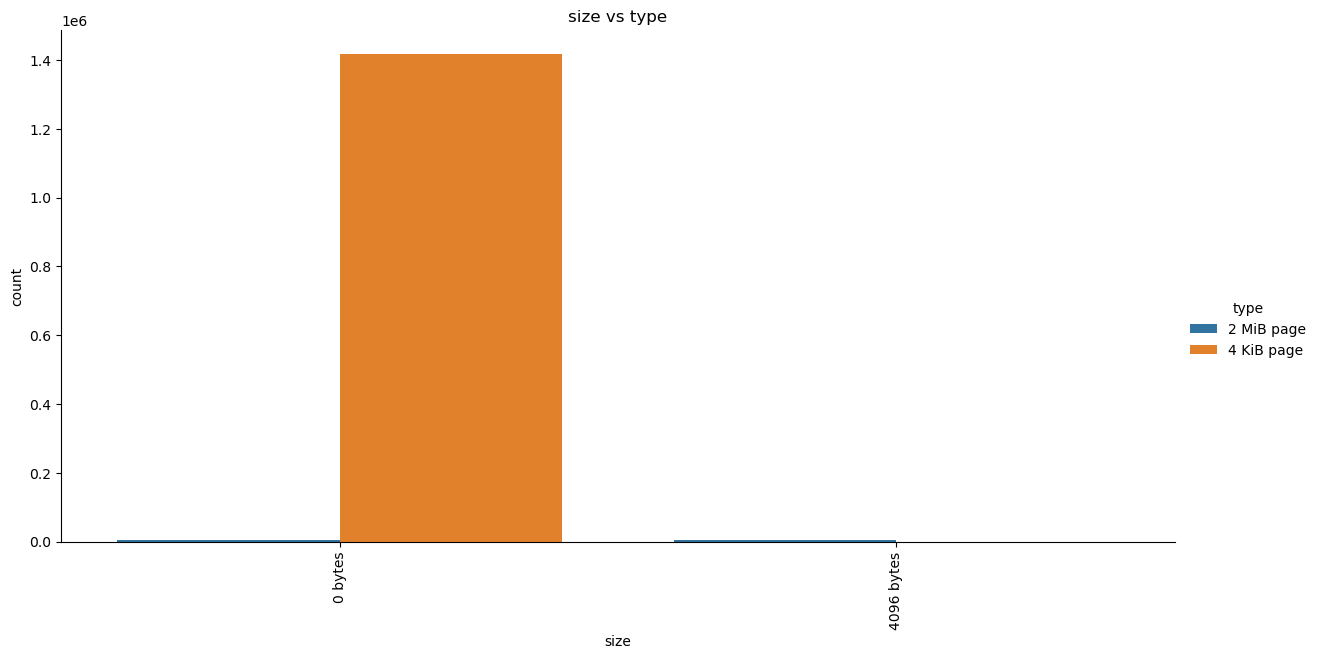

In [36]:
pairwise_comparisons = list(itertools.combinations(categorical_input_vars, 2))
for cat1, cat2 in pairwise_comparisons:
    sns.catplot(data=df_clean,
                x=cat1, 
                hue=cat2, 
                kind='count', 
                aspect=2, 
                height=6)
    plt.title(f'{cat1} vs {cat2}')
    plt.xticks(rotation=90)
    plt.show()

##### Categorical-to-Categorical Heatmaps

`size` vs `type` heatmap
* The size versus type heatmap provides a precise quantitative view of the relationship between memory content retrieval patterns and page architecture within the RanSMAP dataset, revealing distinct operational characteristics across different memory management configurations. The visualization displays four distinct intersection cells that illuminate the distribution patterns: 4 KiB pages with 0 bytes showing 1,416,538 operations (represented by the large light-colored cell), 4 KiB pages with 4096 bytes containing only 24 operations (small dark cell), 2 MiB pages with 0 bytes recording 5,276 operations (medium dark cell), and 2 MiB pages with 4096 bytes capturing 4,066 operations (medium dark cell). This cross-tabulation reveals a fascinating asymmetry in memory access behavior, where 4 KiB pages demonstrate an extreme bias toward zero-byte operations (99.998% of all 4 KiB operations), while 2 MiB pages exhibit a more balanced distribution with 56.4% zero-byte operations and 43.6% involving 4096-byte content retrieval. The heatmap's color intensity effectively highlights this disparity, with the dominant light cell representing the overwhelming majority of metadata operations on standard pages, while the darker cells indicate relatively rare but significant data transfer activities. This pattern suggests that 2 MiB large pages are more frequently employed for actual content operations rather than pure address management, potentially reflecting their use in performance-critical applications where bulk data movement is required. The quantitative precision of the heatmap format enables direct comparison of frequencies across all four combinations, demonstrating that while 2 MiB pages represent only 0.66% of total operations, they account for a disproportionately high percentage (99.4%) of all actual content transfer operations in the dataset, making them particularly significant for understanding memory-intensive ransomware behaviors.

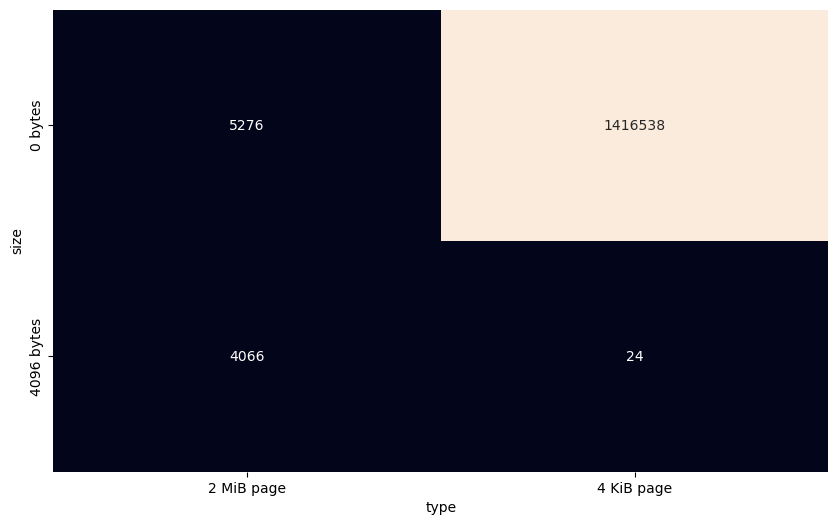

In [37]:
pairwise_comparisons = list(itertools.combinations(categorical_input_vars, 2))
for cat1, cat2 in pairwise_comparisons:
    crosstab = pd.crosstab(df_clean[cat1], df_clean[cat2])
    plt.figure(figsize=(10, 6))
    sns.heatmap(crosstab, annot=True, annot_kws={'size': 10}, fmt='d', cbar=False)
    plt.show()

#### Categorical-to-Continuous Relationships or Conditional Distributions: Box Plots, Violin Plots and Point Plots

##### Categorical-to-Continuous Box Plots

`GPA` vs `size` box plot
* The GPA versus size box plot reveals distinct memory addressing patterns associated with different content retrieval operations within the RanSMAP dataset, demonstrating how memory content size influences the distribution of Guest Physical Addresses. The visualization shows that operations involving 0 bytes of content exhibit an extremely wide range of GPA values with significant variability, spanning the entire memory address space from near zero to approximately 2.5 × 10^11, with the box plot displaying a compressed interquartile range near the lower end of the scale and extensive outlier distribution across higher memory addresses. In contrast, operations involving 4096-byte content retrieval demonstrate a markedly more concentrated GPA distribution, with the box plot showing a much tighter interquartile range and fewer outliers, suggesting that actual data transfer operations tend to access more predictable memory regions. The median GPA values differ substantially between the two size categories, with zero-byte operations showing a median in the lower memory range while 4096-byte operations exhibit a slightly elevated median position. This pattern indicates that metadata operations (0 bytes) access a diverse range of memory locations including system tables, process control blocks, and various memory management structures scattered throughout the address space, while actual content operations (4096 bytes) tend to focus on more organized memory regions such as allocated data pages, buffer areas, and application-specific memory segments.

`entropy` vs `size` box plot
* The entropy versus size box plot unveils a fundamental relationship between memory content randomness and the nature of memory access operations in the RanSMAP dataset, revealing distinct entropy characteristics associated with different content retrieval patterns. For operations involving 0 bytes of content, the box plot displays a bimodal distribution with the median positioned at -1.0 entropy, accompanied by a substantial interquartile range that encompasses both the -1.0 and 0.0 entropy peaks, reflecting the dataset's characteristic polarization between highly structured and normalized entropy values. The zero-byte operations show extensive variability with outliers spanning the entire entropy spectrum from -1.0 to positive values, indicating that metadata operations encounter both highly ordered data structures and various entropy-processed content. Conversely, operations involving 4096-byte content retrieval exhibit a dramatically different entropy profile, with the box plot showing a median closer to 0.0 entropy and a more constrained distribution that suggests these actual data transfer operations predominantly involve structured, low-randomness content. The interquartile ranges reveal that while zero-byte operations experience the full spectrum of entropy values reflecting diverse memory management activities, 4096-byte operations are more concentrated around lower entropy values, indicating they primarily handle organized data structures, initialized memory pages, or repetitive content patterns rather than encrypted or highly random data.

`GPA` vs `type` box plot
* The GPA versus type box plot illuminates the relationship between memory page architecture and address space utilization within the RanSMAP dataset, revealing how different page sizes correspond to distinct Guest Physical Address distribution patterns. Operations on 4 KiB pages demonstrate an extremely wide GPA distribution with significant variability, spanning the complete memory address range from near zero to approximately 2.5 × 10^11, with the box plot showing a compressed interquartile range in the lower address space and extensive outlier distribution extending across higher memory regions. This broad distribution reflects the ubiquitous nature of standard 4 KiB pages, which are employed throughout the entire virtual memory system for diverse applications including code segments, data pages, stack areas, and system structures. In contrast, 2 MiB large pages exhibit a more concentrated GPA distribution pattern, with the box plot displaying a tighter interquartile range and reduced outlier spread, suggesting that large pages are allocated in more predictable memory regions. The median GPA values show notable differences between page types, with 4 KiB pages having a lower median address while 2 MiB pages demonstrate a slightly elevated median position. This distribution pattern indicates that 2 MiB large pages are typically reserved for specific high-performance applications and are allocated in more organized memory regions, potentially reflecting their use in database systems, scientific computing applications, or performance-critical software components that benefit from reduced translation lookaside buffer pressure.

`entropy` vs `type` box plot
* The entropy versus type box plot reveals distinct patterns of memory content randomness across different page architectures in the RanSMAP dataset, demonstrating how memory page size influences the entropy characteristics of accessed content. For 4 KiB pages, the box plot displays the characteristic bimodal distribution with a median positioned at -1.0 entropy and an interquartile range that spans both major entropy peaks, reflecting the predominant polarization between highly structured data (0.0 entropy) and normalized entropy values (-1.0). The extensive variability shown by numerous outliers across the entropy spectrum indicates that standard 4 KiB pages handle the full diversity of memory content types, from highly ordered system structures to various levels of processed or encrypted data. In comparison, 2 MiB large pages exhibit a notably different entropy profile, with the box plot showing a median closer to 0.0 entropy and a more compressed distribution that suggests these large pages predominantly contain structured, low-randomness content. The interquartile range for 2 MiB pages is more constrained and shifted toward lower entropy values, indicating that large pages are primarily employed for organized data structures, application buffers, or database pages rather than highly randomized content. This distinction suggests that 2 MiB pages serve specialized roles in memory management, handling bulk data operations that involve more predictable, structured content patterns, while 4 KiB pages accommodate the broader spectrum of memory management activities including both routine metadata operations and diverse application data with varying entropy characteristics.

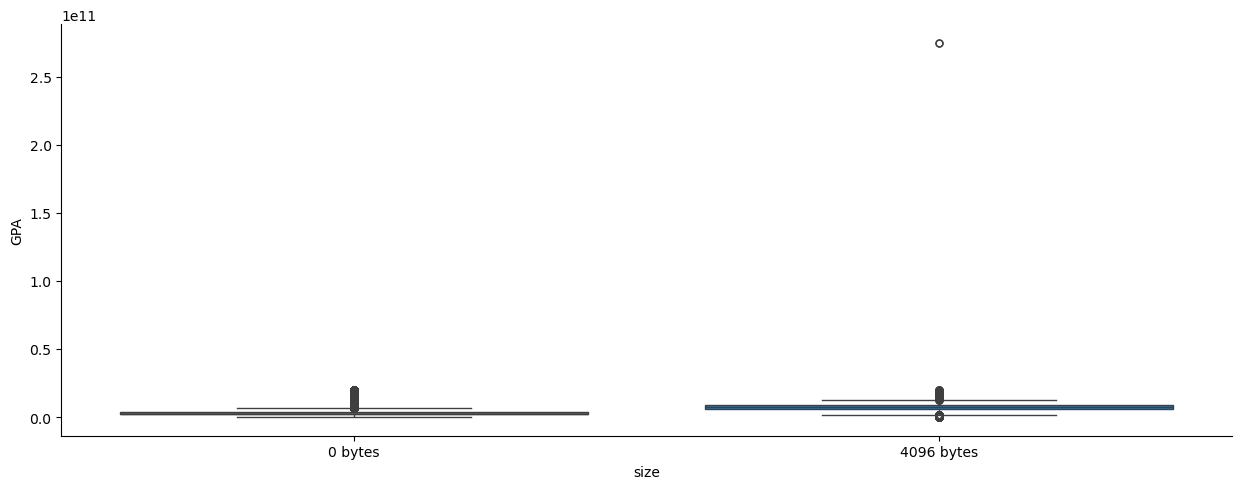

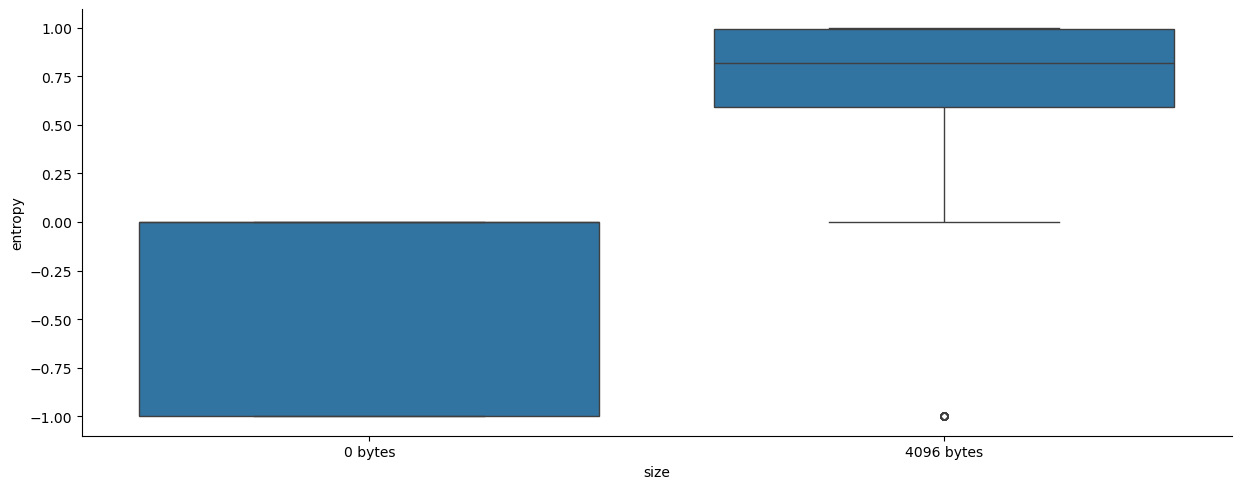

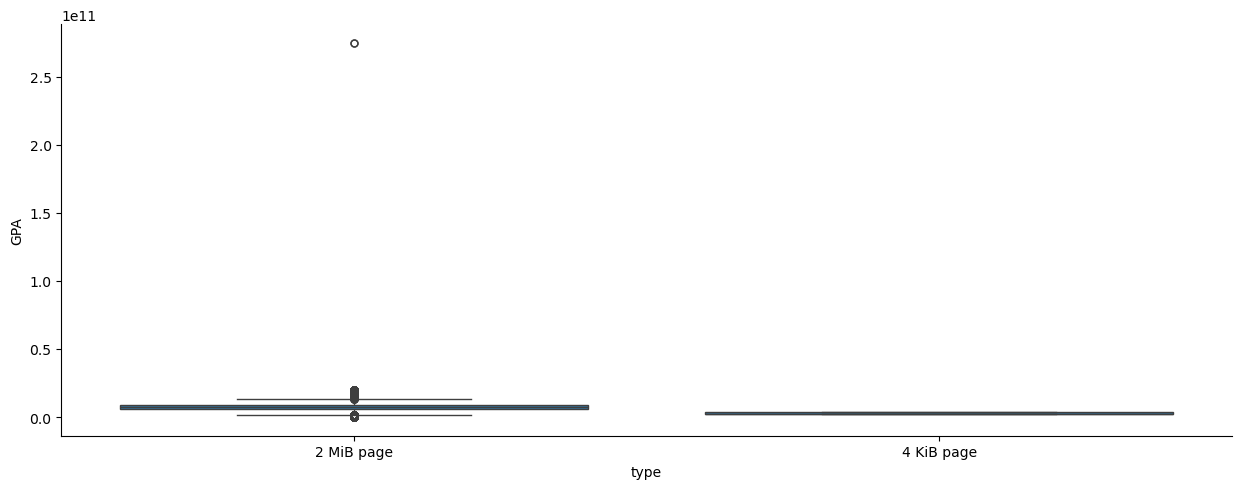

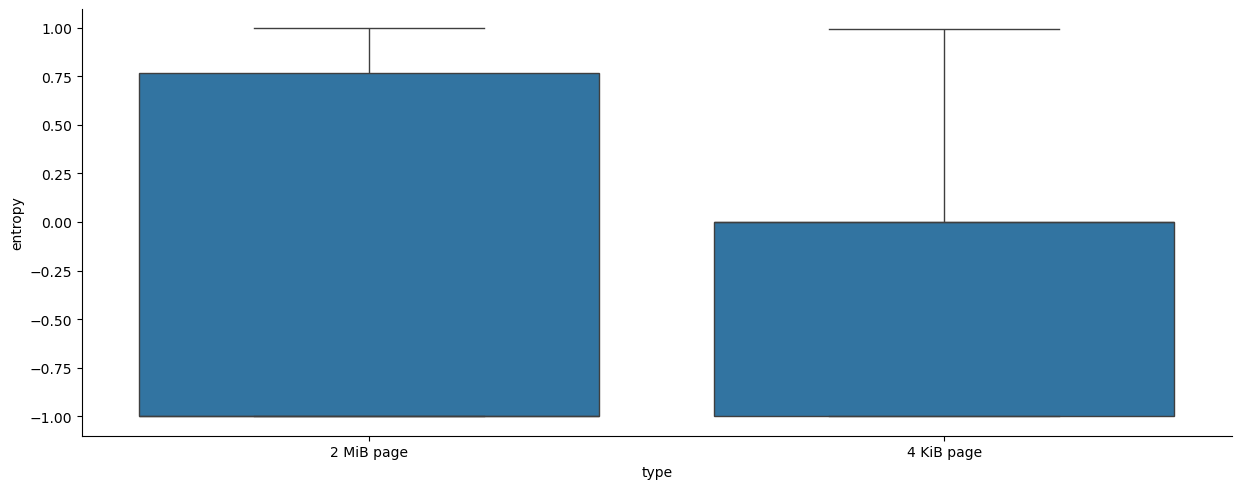

In [38]:
for categorical_input_var in categorical_input_vars:
    for continuous_input_var in continuous_input_vars:
        sns.catplot(data=df_clean,
                    x=categorical_input_var, 
                    y=continuous_input_var, 
                    kind='box', 
                    aspect=2.5, 
                    height=5)
        plt.show()

##### Categorical-to-Continuous Violin Plots

`GPA` vs `size` violin plot
* The GPA versus size violin plot provides a detailed density visualization that reveals the complete distribution shapes and concentration patterns of Guest Physical Addresses across different memory content retrieval operations in the RanSMAP dataset. For operations involving 0 bytes of content, the violin shape demonstrates an extremely narrow, elongated distribution concentrated near the baseline, with the violin's width indicating that the vast majority of these metadata operations access memory addresses in the lower range (below 0.5 × 10^11), while maintaining an extended tail that reaches the maximum GPA values around 2.5 × 10^11. The violin's density contours show multiple subtle peaks within the zero-byte category, suggesting discrete clustering around specific frequently accessed memory regions, which is characteristic of system-level memory management operations that repeatedly reference page tables, process control blocks, and kernel data structures. In stark contrast, operations involving 4096-byte content retrieval exhibit a dramatically different violin profile, with a much wider, more diamond-shaped distribution that indicates greater density concentration around specific GPA ranges. The 4096-byte violin shows a more symmetric distribution with its widest point positioned at an elevated GPA level, suggesting that actual data transfer operations are more predictably allocated within organized memory regions such as application heap areas, buffer pools, and data segment spaces. The violin plot's kernel density estimation effectively illustrates that while zero-byte operations demonstrate high variability with sparse density across the entire address space, 4096-byte operations show concentrated density around specific memory regions optimized for bulk data handling.

`entropy` vs `size` violin plot
* The entropy versus size violin plot unveils the complete probability density distributions of memory content randomness patterns associated with different content retrieval operations, providing crucial insights into the structural characteristics of memory access behaviors within the RanSMAP dataset. For operations involving 0 bytes of content, the violin displays a distinctive bimodal shape with two prominent bulges corresponding to the dataset's characteristic entropy polarization: a substantial density concentration at -1.0 entropy and another major concentration at 0.0 entropy, connected by a narrow waist that represents the sparse distribution of intermediate entropy values. This hourglass-shaped violin demonstrates that metadata operations predominantly encounter either highly normalized entropy content (represented by the -1.0 bulge) or completely structured data (represented by the 0.0 bulge), with minimal presence of partially randomized content in the intermediate range. The violin's asymmetric profile, with slightly greater density at the -1.0 entropy peak, reflects the prevalence of entropy-processed memory management data. Conversely, operations involving 4096-byte content retrieval present a markedly different violin profile, exhibiting a more tapered, asymmetric distribution heavily concentrated toward the 0.0 entropy region with a pronounced density peak near zero randomness. The 4096-byte violin shows a narrower overall shape with limited density extension toward higher entropy values, indicating that actual data transfer operations predominantly involve structured, organized content rather than encrypted or highly randomized data. The violin's concentration around low entropy values suggests that bulk data operations typically handle initialized memory pages, repeated data patterns, or organized file structures rather than the diverse entropy spectrum encountered in metadata operations.

`GPA` vs `type` violin plot
* The GPA versus type violin plot reveals comprehensive density distributions that illuminate the relationship between memory page architecture and Guest Physical Address allocation patterns across the entire memory address space in the RanSMAP dataset. The 4 KiB page violin demonstrates an extremely narrow, linear distribution concentrated near the baseline with minimal width variation, reflecting the overwhelming dominance of these standard pages throughout the entire GPA range from near zero to approximately 2.5 × 10^11. The violin's elongated, pencil-thin profile indicates that while 4 KiB pages span the complete memory address spectrum, the vast majority are allocated within the lower address ranges, with the violin showing consistent minimal density across higher memory regions. This distribution pattern reflects the ubiquitous nature of standard 4 KiB pages, which serve as the fundamental unit for virtual memory management across diverse system components including application code, data segments, stack areas, and system structures. In contrast, the 2 MiB large page violin exhibits a dramatically different profile with a more substantial, diamond-shaped distribution that indicates concentrated density around specific GPA ranges. The 2 MiB violin shows a wider profile with its maximum density occurring at a more elevated GPA position, suggesting that large pages are strategically allocated within organized memory regions optimized for high-performance applications. The violin's more compact vertical range and increased width demonstrate that 2 MiB pages are less dispersed across the address space and instead concentrated in predictable memory zones, likely corresponding to database buffer pools, scientific computing applications, or performance-critical software components that benefit from reduced memory management overhead.

`entropy` vs `type` violin plot
* The entropy versus type violin plot provides a comprehensive view of memory content randomness distributions across different page architectures, revealing fundamental differences in how content entropy varies between standard and large memory pages in the RanSMAP dataset. The 4 KiB page violin exhibits the characteristic bimodal distribution with two distinct bulges representing the entropy polarization: a substantial concentration at -1.0 entropy and another major peak at 0.0 entropy, connected by a narrow constriction that demonstrates the relative scarcity of intermediate entropy values. This hourglass-shaped violin reflects the diverse range of content types handled by standard 4 KiB pages, from highly normalized entropy-processed data (lower bulge) to completely structured, ordered content (upper bulge near 0.0), with minimal density in the transitional entropy ranges. The violin's balanced bimodal profile indicates that 4 KiB pages accommodate both routine metadata operations involving entropy-normalized content and structured application data with zero randomness. In marked contrast, the 2 MiB large page violin presents a dramatically different distribution profile, showing a more concentrated, asymmetric shape heavily weighted toward the 0.0 entropy region with a pronounced density peak at low randomness values. The 2 MiB violin demonstrates a tapered form with limited extension toward higher entropy values, indicating that large pages predominantly handle structured, organized content rather than the diverse entropy spectrum characteristic of standard pages. The violin's concentration around low entropy values, combined with its reduced presence at the -1.0 entropy peak, suggests that 2 MiB pages are primarily employed for bulk data operations involving predictable content patterns such as database pages, application buffers, or organized file structures, rather than the diverse mix of metadata and processed content typical of 4 KiB page operations.

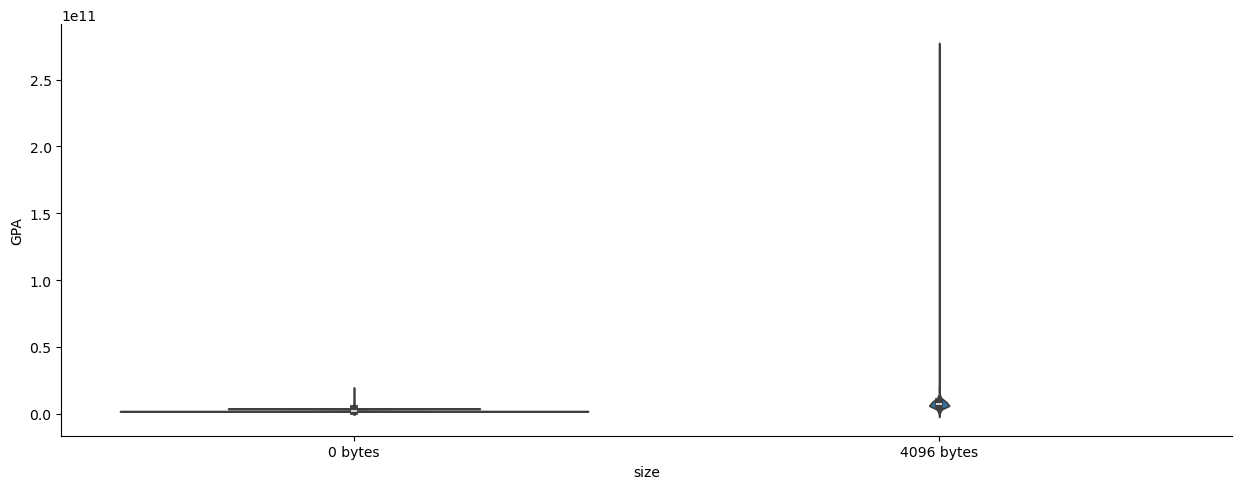

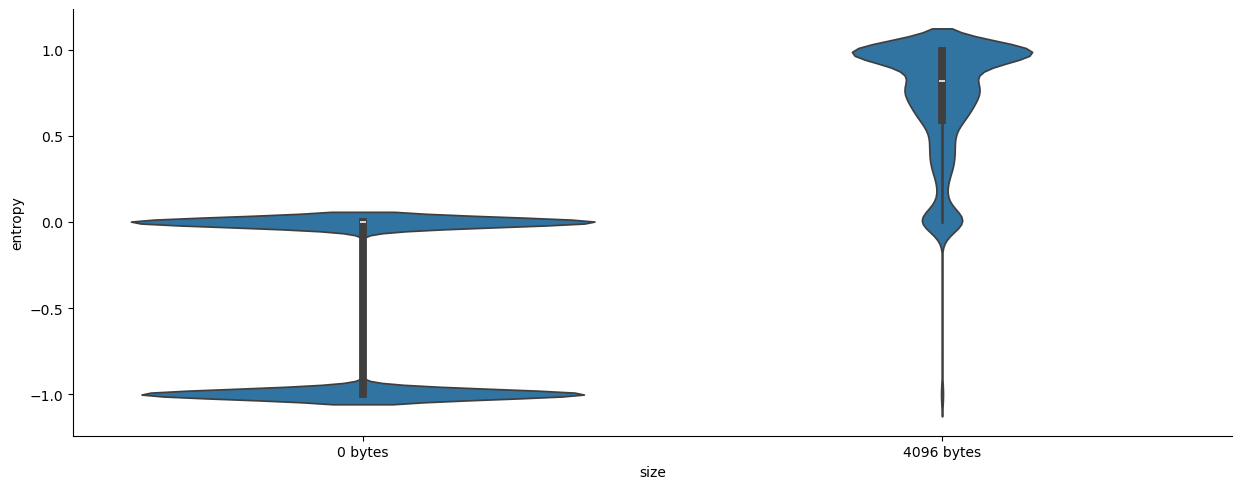

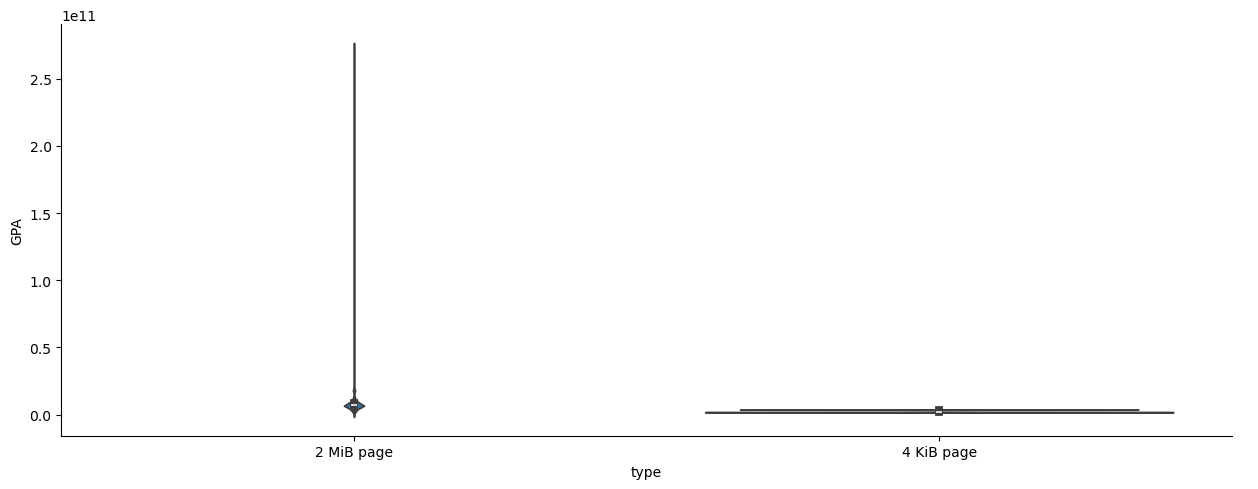

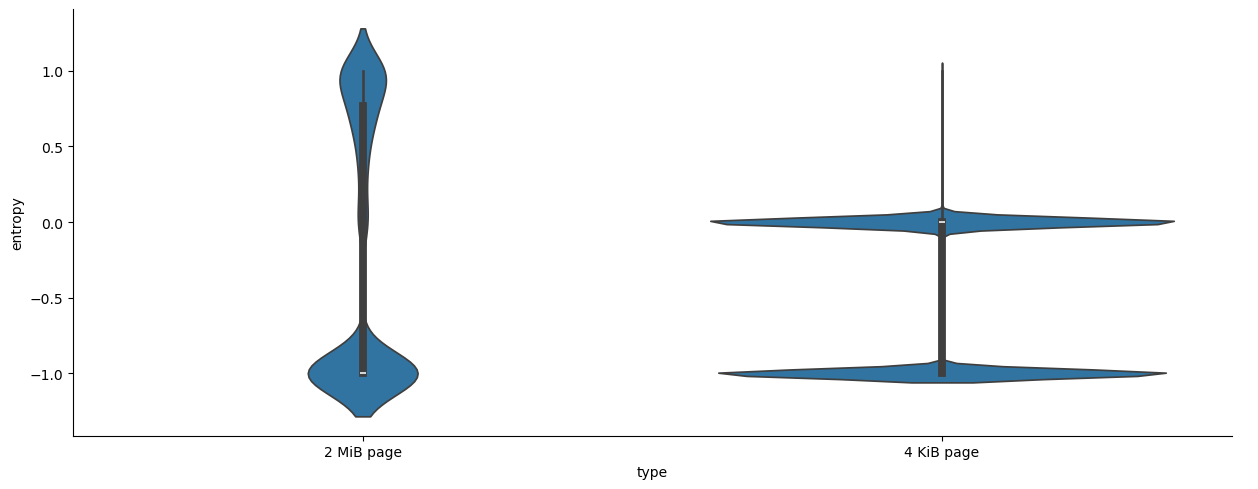

In [39]:
for categorical_input_var in categorical_input_vars:
    for continuous_input_var in continuous_input_vars:
        sns.catplot(data=df_clean,
                    x=categorical_input_var, 
                    y=continuous_input_var, 
                    kind='violin', 
                    aspect=2.5, 
                    height=5)
        plt.show()

##### Categorical-to-Continuous Point Plots

`GPA` vs `size` point plot
* The GPA versus size point plot presents a clear statistical summary of the central tendency differences in Guest Physical Address values between different memory content retrieval operations, revealing a substantial elevation in mean GPA values for actual data transfer activities within the RanSMAP dataset. The visualization demonstrates that operations involving 0 bytes of content exhibit a mean GPA value positioned at approximately 2.75 × 10^9, while operations involving 4096-byte content retrieval show a dramatically elevated mean GPA value at approximately 7.6 × 10^9, representing nearly a threefold increase in average memory address positioning. The confidence intervals, depicted by the vertical error bars, indicate relatively tight precision around both mean estimates, with the zero-byte operations showing slightly wider confidence bounds that reflect the greater variability in metadata operation addressing patterns. This substantial difference in mean GPA values suggests a fundamental architectural distinction in memory allocation strategies, where metadata operations (zero-byte transfers) predominantly access lower memory regions associated with system structures, page tables, and kernel data areas, while actual content operations (4096-byte transfers) are allocated in elevated memory regions optimized for application data, buffer management, and user-space operations. The point plot's clear separation between these two means, combined with non-overlapping confidence intervals, indicates a statistically significant difference that could serve as a discriminative feature for distinguishing between different types of memory access patterns in ransomware detection models.

`entropy` vs `size` point plot
* The entropy versus size point plot reveals a striking contrast in mean entropy characteristics between different memory content retrieval operations, illustrating fundamental differences in the randomness patterns associated with metadata versus actual data transfer activities in the RanSMAP dataset. Operations involving 0 bytes of content demonstrate a mean entropy value positioned at approximately -0.5, indicating a central tendency toward the normalized entropy processing characteristic of metadata operations, while operations involving 4096-byte content retrieval exhibit a substantially elevated mean entropy value at approximately 0.7, representing a shift toward higher randomness levels typical of actual data content. The confidence intervals shown by the vertical error bars are relatively constrained for both categories, with the zero-byte operations displaying slightly wider bounds that reflect the bimodal nature of entropy distribution in metadata operations spanning both -1.0 and 0.0 entropy peaks. This significant difference in mean entropy values, with actual data operations showing approximately 1.2 units higher average entropy than metadata operations, suggests that bulk data transfers involve content with greater inherent randomness, potentially including compressed files, encrypted data, or complex application content structures. The clear separation between these mean entropy values, combined with non-overlapping confidence intervals, indicates that entropy characteristics serve as a strong discriminative feature for distinguishing between memory access operation types, which could be particularly valuable for identifying ransomware behaviors that typically involve high-entropy encrypted content manipulation compared to routine system metadata operations.

`GPA` vs `type` point plot
* The GPA versus type point plot demonstrates a remarkable disparity in mean Guest Physical Address values between different memory page architectures, revealing distinct allocation strategies for standard versus large page memory management within the RanSMAP dataset. The visualization shows that 2 MiB large pages exhibit a mean GPA value positioned at approximately 7.8 × 10^9, while 4 KiB standard pages demonstrate a substantially lower mean GPA value at approximately 2.7 × 10^9, indicating that large pages are allocated at nearly three times higher memory addresses on average compared to standard pages. The confidence intervals, represented by the vertical error bars, show relatively tight precision around both estimates, with 4 KiB pages displaying slightly wider confidence bounds that reflect the greater diversity of allocation patterns across the vast number of standard page operations. This significant elevation in mean GPA values for large pages suggests a deliberate memory management strategy where 2 MiB pages are reserved for higher memory regions, potentially to optimize memory translation efficiency and avoid fragmentation in lower address spaces heavily utilized by standard 4 KiB page operations. The substantial difference between these means, with non-overlapping confidence intervals, indicates that memory page type serves as a strong predictor of address space utilization patterns, which could be particularly relevant for ransomware detection since malicious software may exhibit different memory allocation behaviors when performing bulk encryption operations that could benefit from large page architectures versus routine file system operations typically handled by standard pages.

`entropy` vs `type` point plot
* The entropy versus type point plot reveals a notable difference in mean entropy characteristics between different memory page architectures, demonstrating how page size influences the average randomness of content accessed within the RanSMAP dataset's memory operations. The visualization indicates that 2 MiB large pages exhibit a mean entropy value positioned at approximately -0.25, while 4 KiB standard pages show a lower mean entropy value at approximately -0.49, representing a difference of about 0.24 entropy units between the two page types. The confidence intervals depicted by the vertical error bars are relatively narrow for both page types, with 2 MiB pages showing slightly tighter bounds that reflect the more constrained entropy distribution characteristic of large page operations, while 4 KiB pages display wider confidence intervals consistent with their broader entropy spectrum spanning both major peaks of the bimodal distribution. This elevation in mean entropy for large pages suggests that 2 MiB page operations involve content with slightly higher average randomness compared to standard pages, which could reflect their specialized use in performance-critical applications that handle more diverse data types, including compressed content, multimedia data, or complex application structures that inherently possess higher entropy characteristics. The statistically significant difference between these means, evidenced by the non-overlapping confidence intervals, indicates that memory page architecture influences content entropy patterns in ways that could be relevant for ransomware detection, particularly since malicious encryption operations might exhibit different entropy signatures when utilizing large pages for bulk processing compared to the routine metadata and system operations typically associated with standard 4 KiB page access patterns.

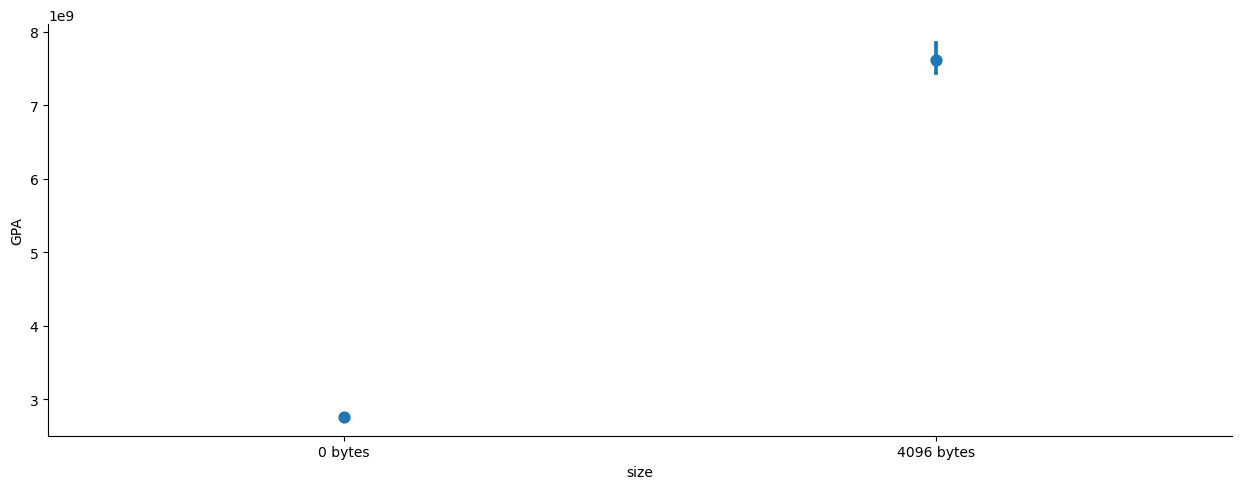

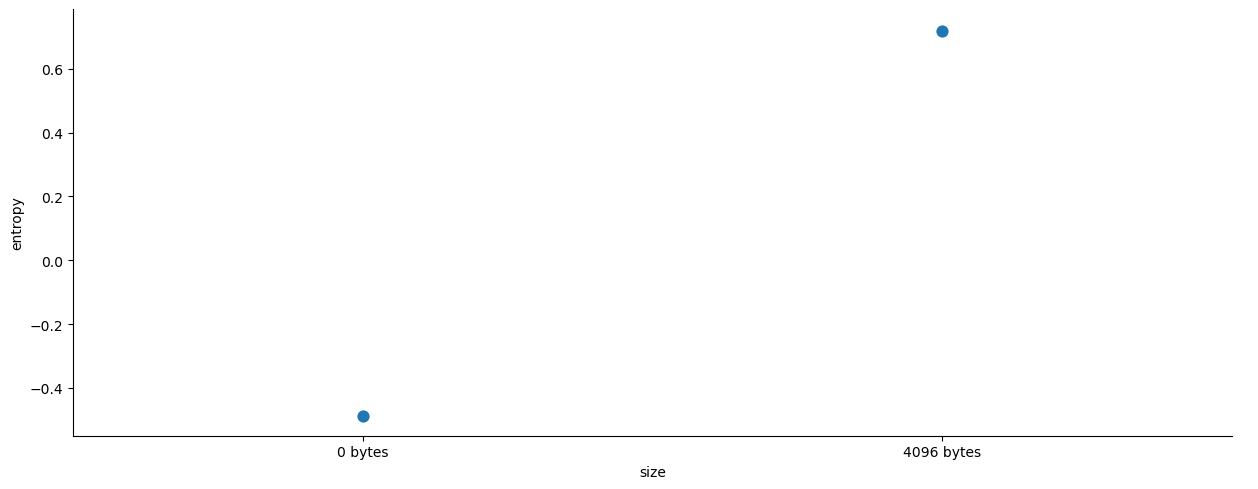

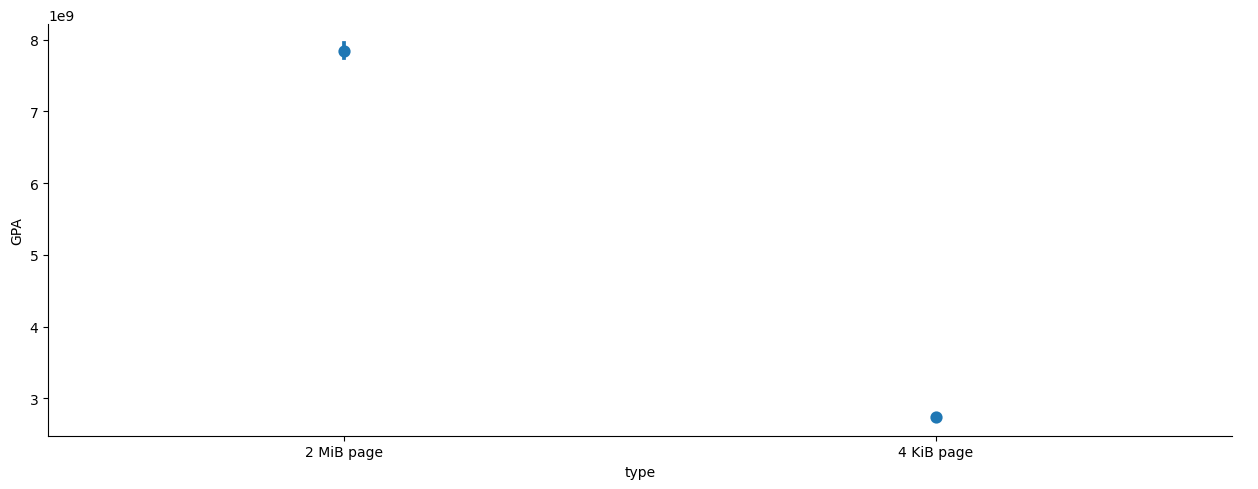

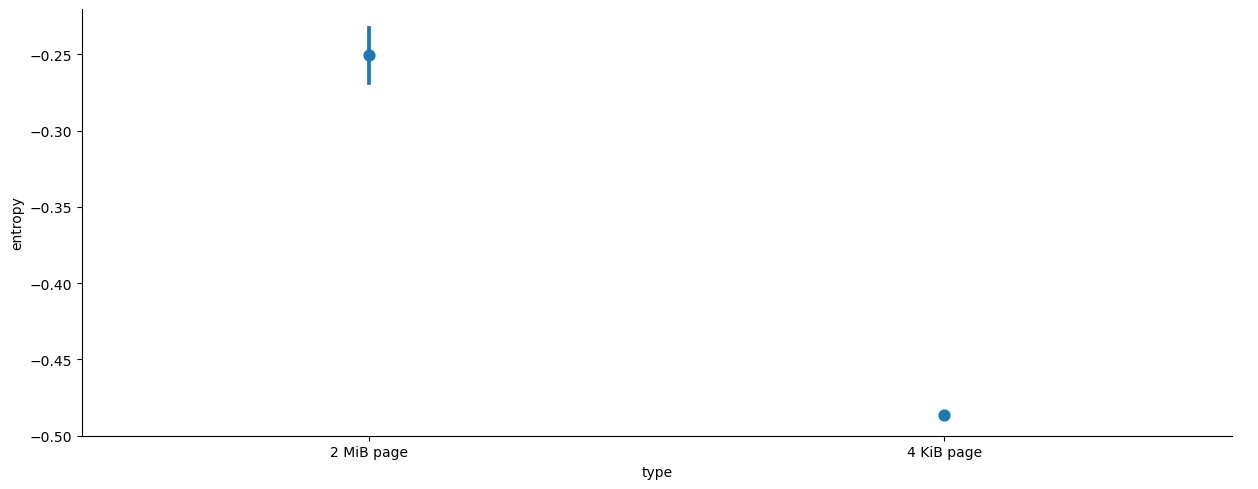

In [40]:
for categorical_input_var in categorical_input_vars:
    for continuous_input_var in continuous_input_vars:
        sns.catplot(data=df_clean,
                    x=categorical_input_var, 
                    y=continuous_input_var, 
                    kind='point', 
                    linestyles='',
                    aspect=2.5, 
                    height=5)
        plt.show()

#### Continuous-to-Continuous Relationships or Conditional Distributions: Pairs Plots and Correlation Plots

##### Continuous-to-Continuous Pairs Plots

* The pairs plot matrix for the continuous variables GPA and entropy provides a comprehensive visualization of their individual distributions and bivariate relationship within the RanSMAP dataset, revealing both the characteristic patterns of each variable and their interdependence across 1.42 million memory access operations. The diagonal elements display the marginal distributions: GPA demonstrates its characteristic highly concentrated distribution with the vast majority of observations clustered near zero (below 0.5 × 10^11) and a sparse tail extending to 2.5 × 10^11, while entropy exhibits its distinctive bimodal structure with prominent peaks at -1.0 and 0.0, representing the polarization between normalized entropy-processed content and completely structured data. The off-diagonal scatter plots reveal the bivariate relationship between these variables, showing a complex interaction pattern where the majority of data points form dense clusters at specific GPA-entropy combinations, particularly concentrated in the lower GPA ranges across both major entropy peaks. The scatter plot indicates that operations with -1.0 entropy are distributed across a wider range of GPA values, suggesting that entropy-normalized content is accessed throughout various memory regions, while operations with 0.0 entropy show more concentrated GPA patterns, indicating that structured content tends to be allocated in more predictable memory locations. Notably, the scatter plot reveals several distinct point clusters that correspond to frequently accessed memory addresses with specific entropy characteristics, reflecting the systematic nature of memory management operations where certain address-entropy combinations represent recurring patterns in system behavior, application data handling, or malware execution signatures that could serve as discriminative features for ransomware detection models.

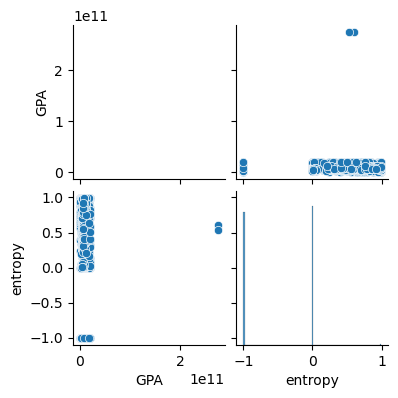

In [41]:
pair_plot = sns.pairplot(data=df_clean[continuous_input_vars], 
                         aspect=1, 
                         height=2)
plt.show()

##### Continuous-to-Continuous Correlation Plots

* The correlation heatmap for the continuous variables GPA and entropy reveals a remarkably weak linear relationship between Guest Physical Address values and memory content randomness within the RanSMAP dataset, indicating that these two fundamental memory access characteristics operate largely independently of each other across the 1.42 million observed operations. The correlation coefficient of 0.011 between GPA and entropy demonstrates virtually no linear association, suggesting that the memory address where an operation occurs does not systematically predict or influence the entropy characteristics of the content accessed at that location. This near-zero correlation is visualized through the light gray coloring in the off-diagonal cells of the heatmap, positioned very close to the neutral center point of the correlation scale that ranges from perfect negative correlation (-1.0, deep blue) through zero correlation (white/light gray) to perfect positive correlation (1.0, deep red). The diagonal elements appropriately display perfect positive correlation (1.0) for each variable with itself, represented by the intense red coloring that serves as the reference point for maximum correlation strength. This independence between memory addressing and content entropy has significant implications for ransomware detection modeling, as it suggests that GPA and entropy provide complementary, non-redundant information about memory access patterns. The lack of correlation indicates that these variables capture distinct aspects of memory behavior: GPA reflects the spatial organization and allocation strategies of memory management systems, while entropy characterizes the structural properties and randomness of the data content itself, making them valuable independent features for machine learning models designed to distinguish between benign and malicious memory access signatures.

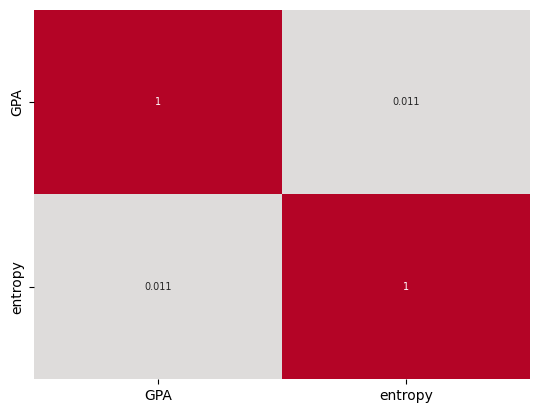

In [42]:
fig, ax = plt.subplots()
sns.heatmap(data=df_clean[continuous_input_vars].\
            corr(numeric_only=True),
            vmin=-1,
            vmax=1,
            center=0,
            cmap='coolwarm',
            cbar=False,
            annot=True,
            annot_kws={'size': 7},
            ax=ax)
plt.show()

### Visualize the Relationship Changes Across Groups

#### Continuous-to-Continuous Response Relationships or Conditional Distributions w/ the Continuous Response and the Continuous Inputs with Trend Plots

##### Continuous-to-Continuous Trend Plots

`GPA` vs `entropy` vs `category` vs `type`

* The multifaceted trend plot matrix examining GPA versus entropy relationships across different categories and memory page types reveals distinct behavioral patterns that differentiate malware families from benign applications within the RanSMAP dataset, providing crucial insights for ransomware classification modeling. Across the twelve category panels, the visualization demonstrates that most categories exhibit consistent bimodal entropy clustering at -1.0 and 0.0 values regardless of GPA positioning, with data points predominantly concentrated in lower memory address ranges (below 1.0 × 10^11). However, several categories display notable deviations from this pattern: the Zip compression utility shows a distinct negative correlation trend line with substantial confidence intervals, indicating that higher GPA values correspond to lower entropy levels, which suggests organized data placement strategies during compression operations. Similarly, LockBit ransomware exhibits a negative correlation trend with wide confidence intervals, potentially reflecting systematic memory allocation patterns during encryption processes where higher memory addresses are associated with more structured content. The color coding distinguishes between 4 KiB pages (blue) and 2 MiB pages (orange), revealing that while most categories are dominated by standard 4 KiB page operations clustered around the characteristic entropy peaks, certain categories like Zip, LockBit, and Ryuk show more pronounced 2 MiB page activity in elevated memory regions. Benign applications such as Firefox, Idle, Office, and SDelete demonstrate relatively tight clustering with minimal trend lines, suggesting consistent memory access patterns, while ransomware families like Darkside, WannaCry, REvil, and Conti exhibit more scattered distributions across both entropy levels and GPA ranges. The trend lines with their associated confidence intervals provide statistical evidence of category-specific relationships between memory addressing and content entropy, indicating that certain malware families exhibit systematic behaviors that could serve as discriminative signatures for classification algorithms, particularly the negative correlations observed in Zip compression and LockBit encryption operations that suggest organized memory management strategies distinct from random or typical application behaviors.

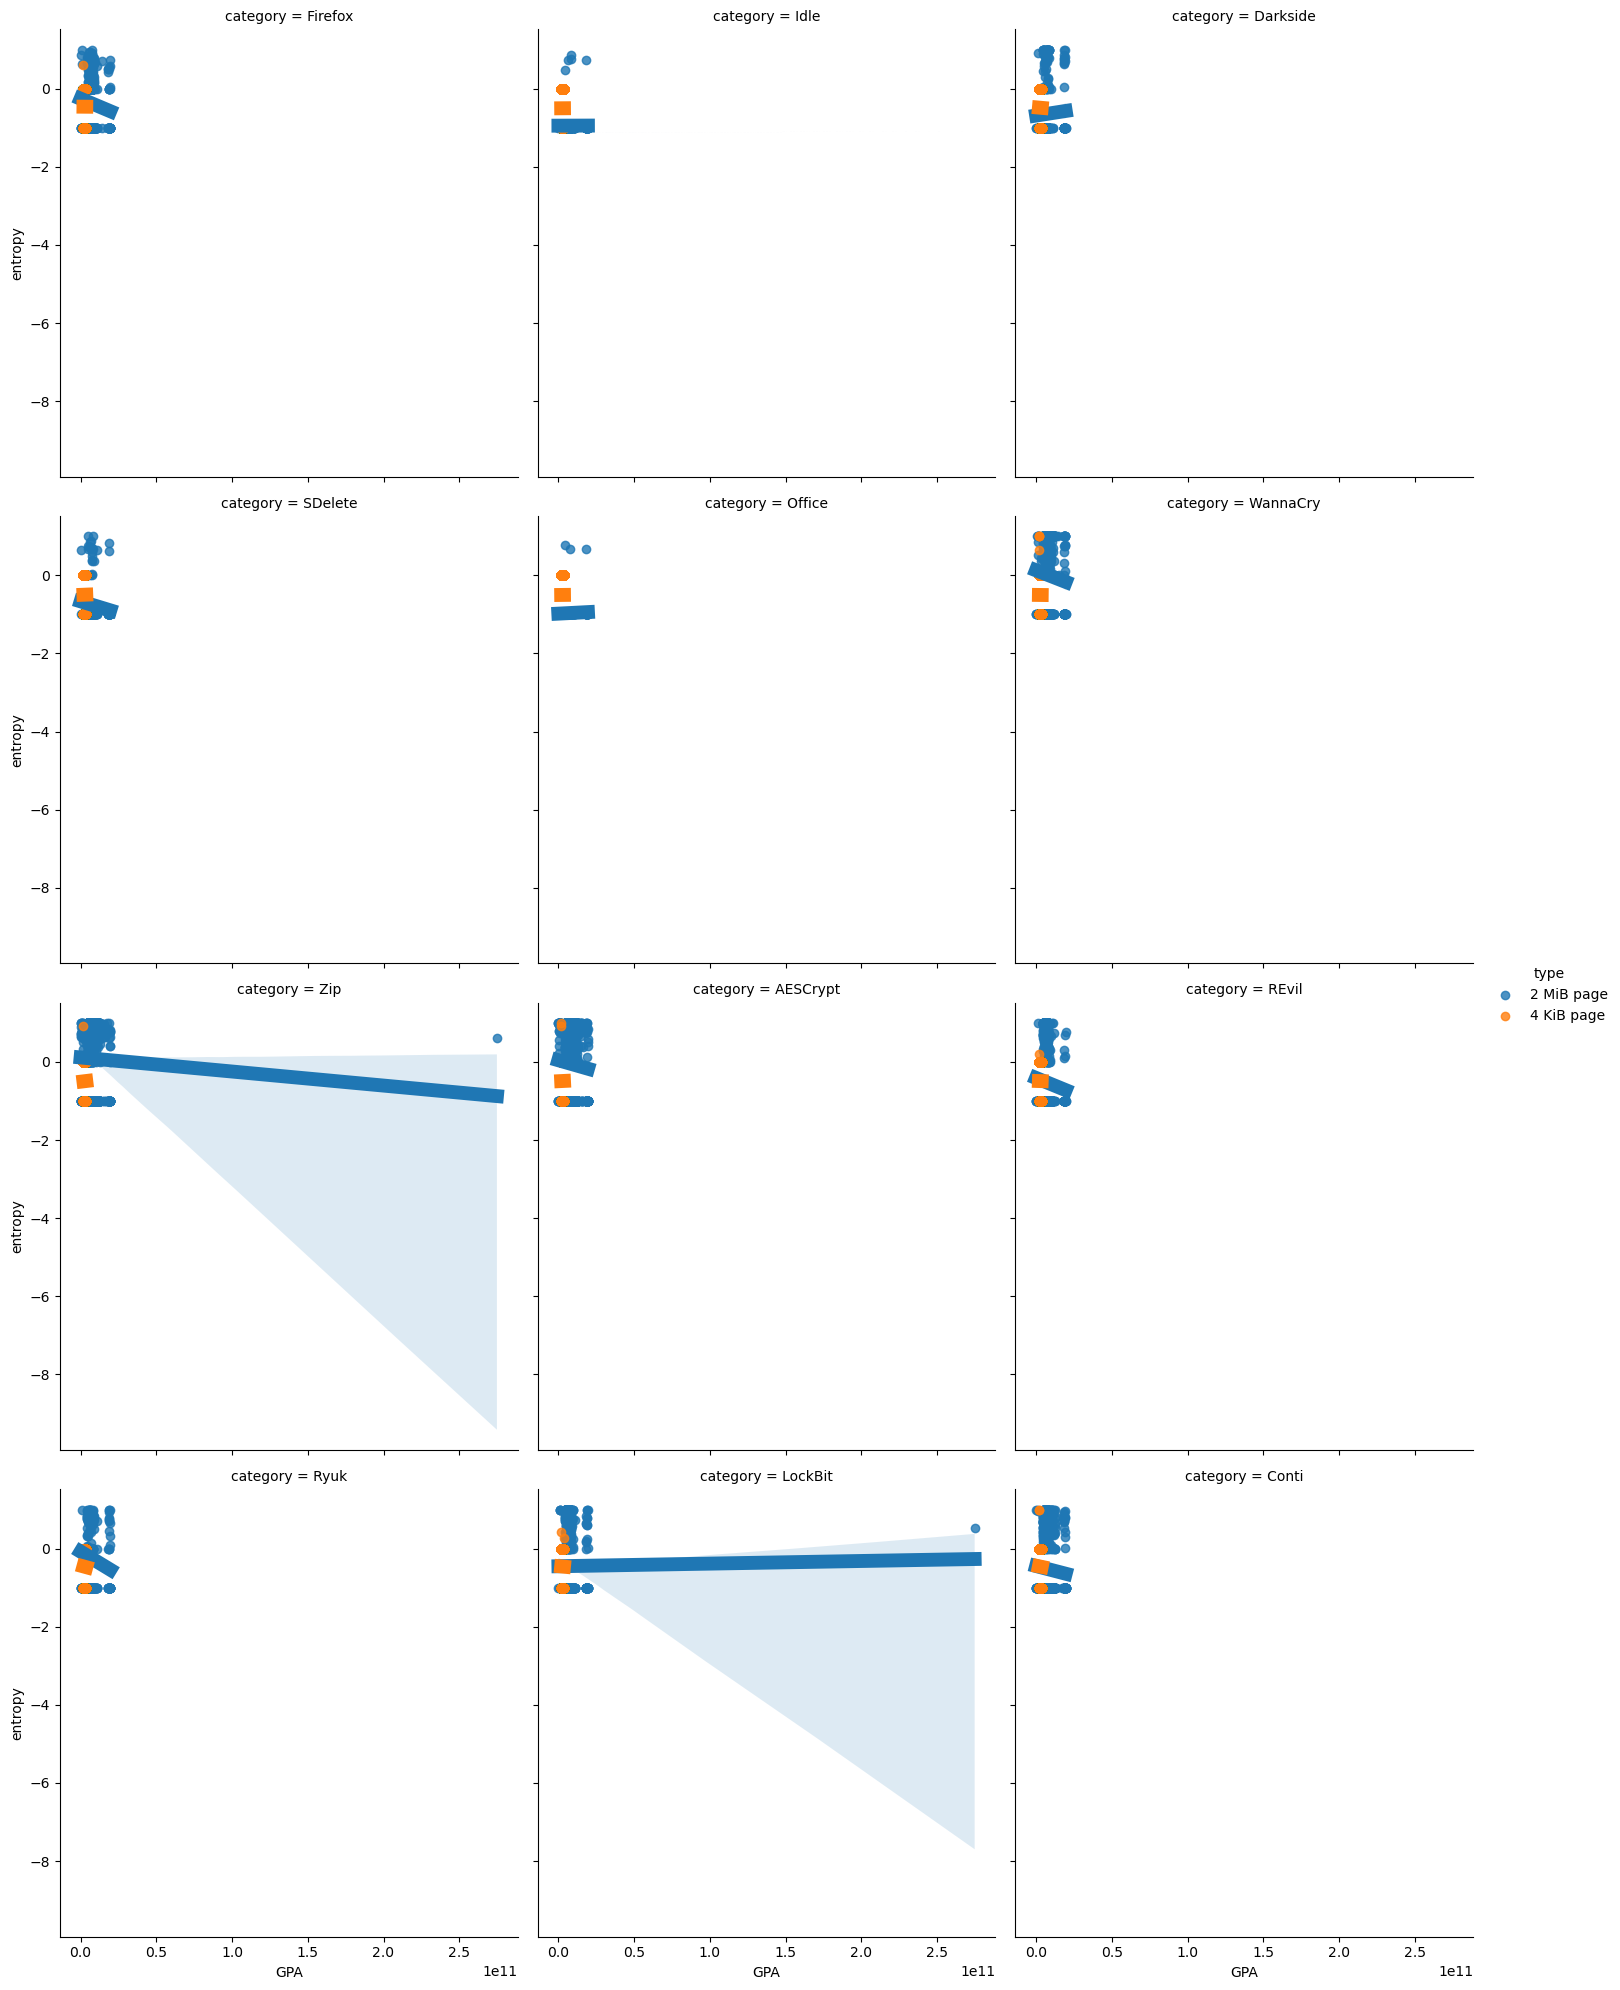

In [43]:
sns.lmplot(data=df_clean,
           x='GPA',
           y='entropy',
           col='category',
           hue='type',
           line_kws={'linewidth': 10},
           col_wrap=3)
plt.show()

`GPA` vs `entropy` vs `category` vs `size`

* The comprehensive trend plot matrix analyzing GPA versus entropy relationships across different categories while distinguishing between memory content sizes reveals sophisticated patterns of memory access behavior that illuminate the operational characteristics of various malware families and benign applications within the RanSMAP dataset. The visualization employs color coding to differentiate between 0-byte operations (blue) and 4096-byte operations (orange), immediately revealing that the vast majority of memory operations across all categories involve zero-byte content retrieval, consistent with metadata-focused memory management activities. However, several categories demonstrate notable deviations and trend patterns that provide insights into their specific operational behaviors. The Zip compression utility exhibits a distinctive positive correlation trend line for 4096-byte operations, with orange points forming an ascending pattern and substantial confidence intervals, suggesting that larger memory addresses correspond to higher entropy levels during compression activities, potentially reflecting the processing of diverse file content types at elevated memory locations. Similarly, LockBit ransomware displays a pronounced flat trend line for 4096-byte operations with wide confidence intervals, indicating consistent entropy levels across different GPA ranges during bulk encryption processes, which represents a systematic approach to memory utilization during malware execution. SDelete shows a notable positive trend for 4096-byte operations, reflecting its disk sanitization methodology where higher memory addresses are associated with increased entropy as the utility processes and overwrites diverse file content types. Benign applications such as Firefox, Idle, Office, and WannaCry demonstrate relatively tight clustering with minimal trend variations, primarily dominated by zero-byte operations clustered around the characteristic bimodal entropy peaks at -1.0 and 0.0. Ransomware families like Darkside, REvil, Ryuk, and Conti exhibit mixed patterns with both operation types present but generally show more constrained distributions compared to the utility applications. The trend analysis reveals that 4096-byte operations, though representing only 0.3% of total operations, exhibit more pronounced correlation patterns and wider confidence intervals across categories, suggesting that actual content transfer operations provide more discriminative behavioral signatures for malware classification than the predominant metadata operations, making them particularly valuable features for machine learning models designed to distinguish between malicious and benign memory access patterns based on content size-specific entropy relationships.

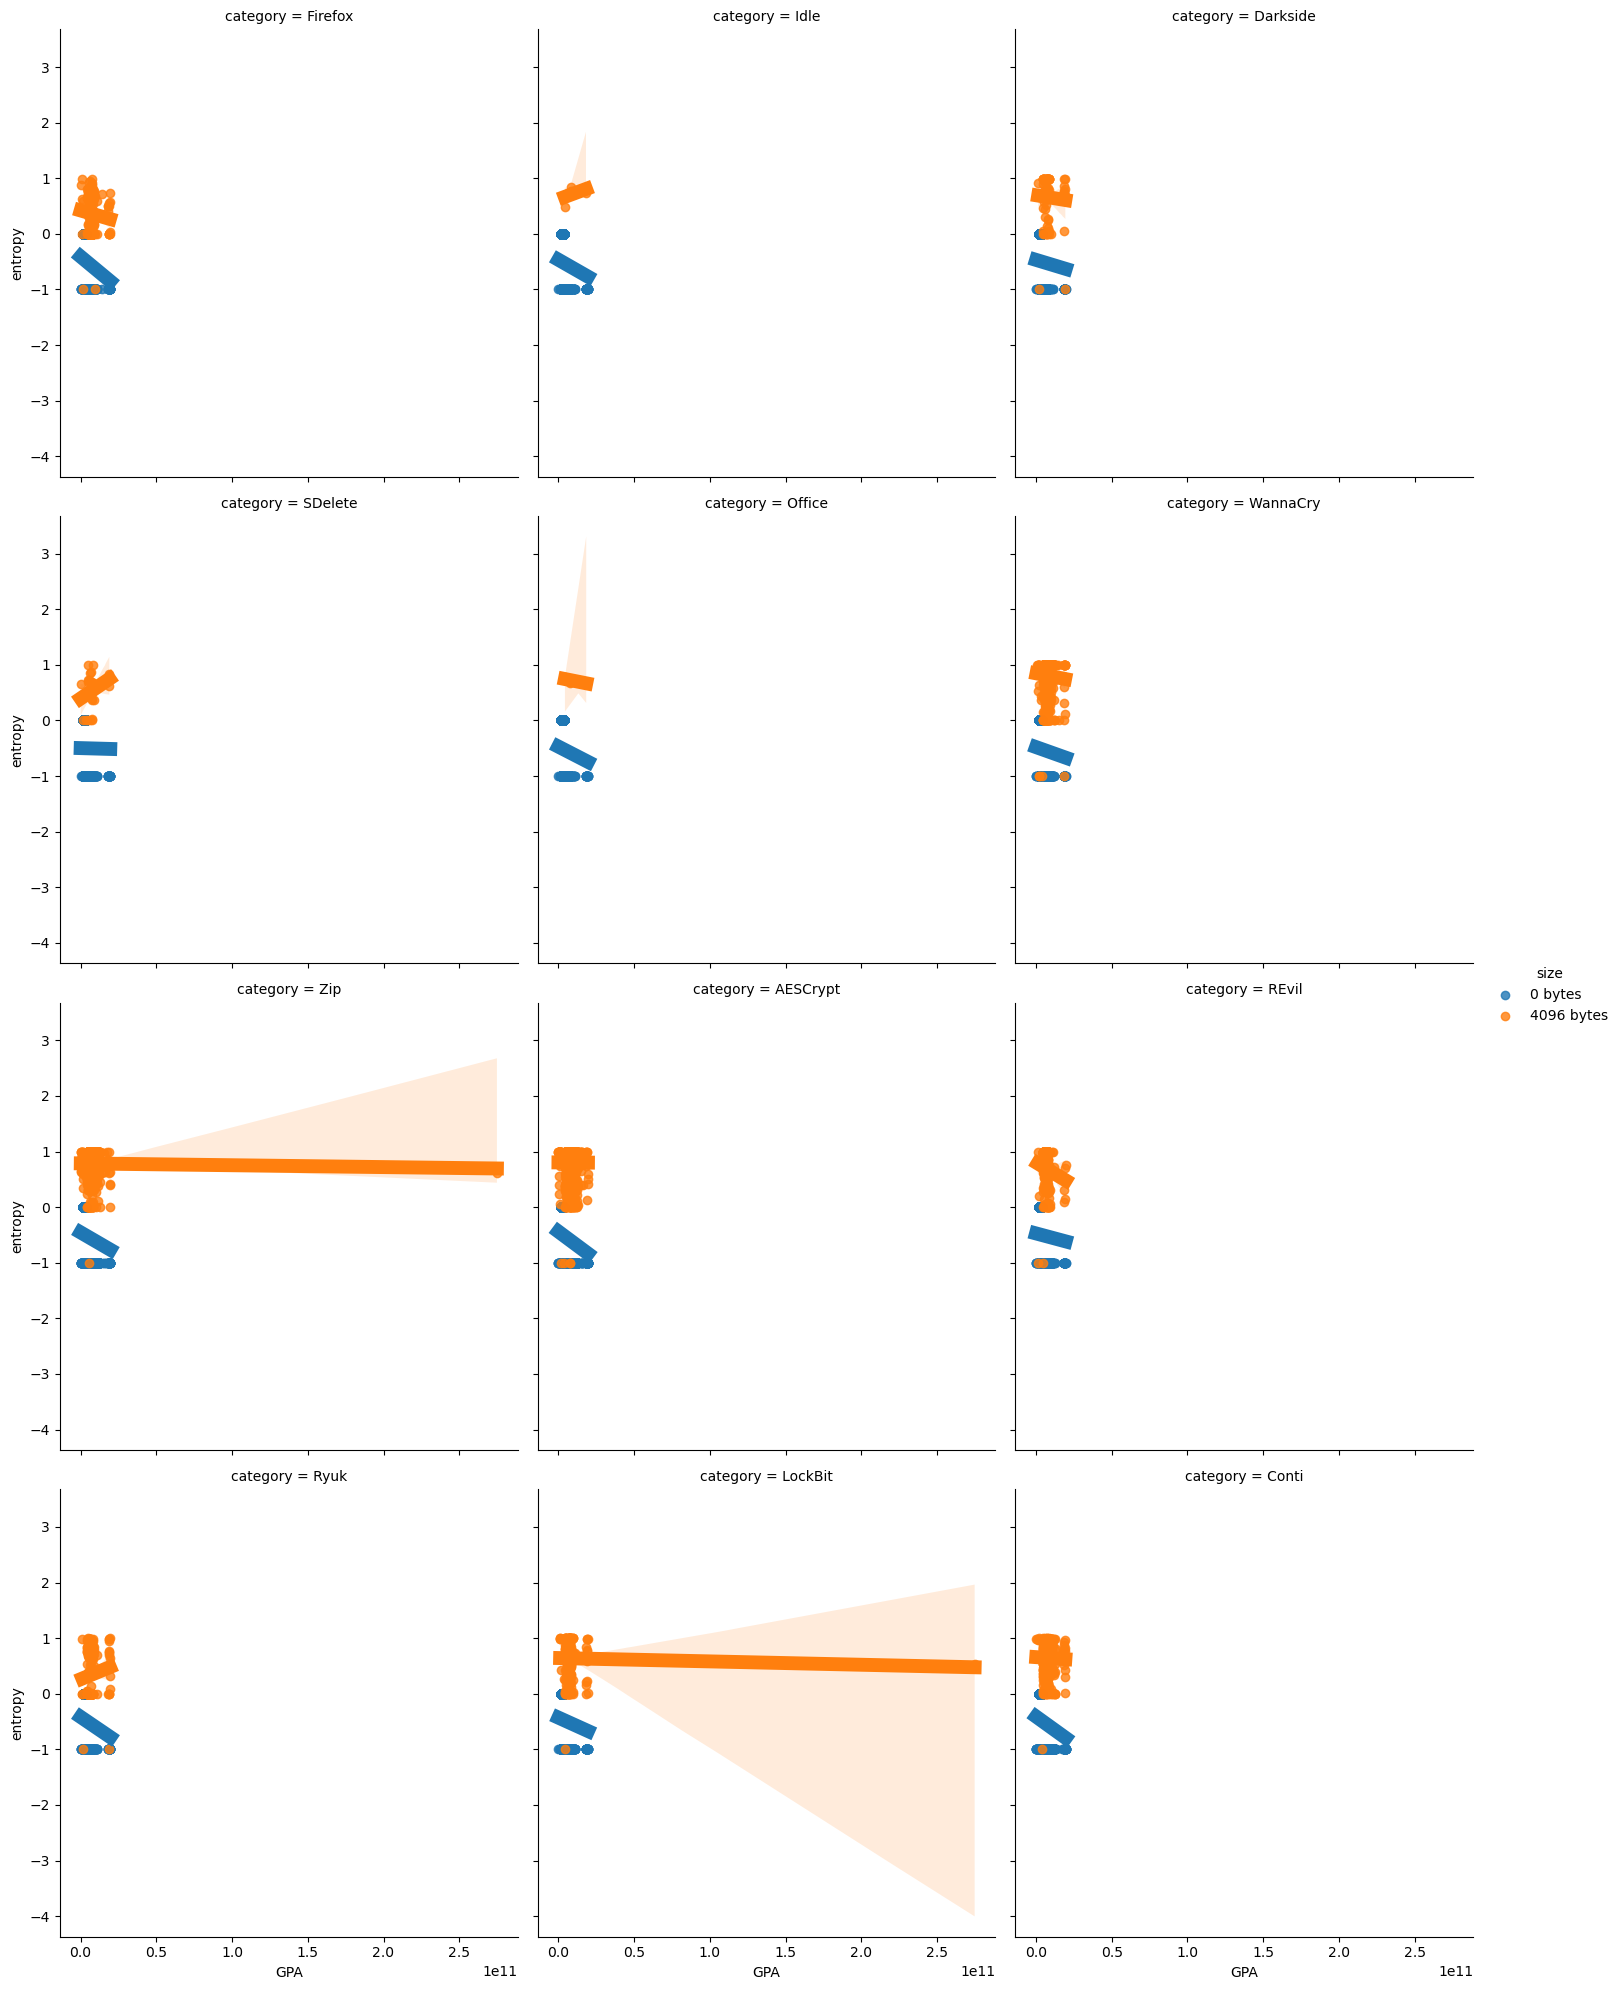

In [44]:
sns.lmplot(data=df_clean,
           x='GPA',
           y='entropy',
           col='category',
           hue='size',
           line_kws={'linewidth': 10},
           col_wrap=3)
plt.show()

`GPA` vs `entropy` vs `type` vs `category`

* The dual-panel trend plot comparing GPA versus entropy relationships across memory page types reveals fundamental architectural differences in how various malware families and benign applications utilize different memory management systems within the RanSMAP dataset. The left panel, representing 2 MiB large pages, displays a remarkably diverse array of trend lines with multiple categories exhibiting distinct correlation patterns and substantial confidence intervals, indicating that large page operations demonstrate category-specific memory access behaviors with significant variability across different software types. The visualization shows numerous overlapping trend lines in various colors, with several categories displaying negative correlations where higher GPA values correspond to lower entropy levels, particularly evident in the convergent pattern of multiple trend lines that slope downward from approximately 0.5 entropy at low GPA values to -1.0 entropy at elevated memory addresses around 2.5 × 10^11. This convergence suggests that large page operations across different categories tend toward more structured, low-entropy content as memory addresses increase, potentially reflecting optimized memory allocation strategies for performance-critical applications that utilize 2 MiB pages for bulk data processing. In stark contrast, the right panel representing 4 KiB standard pages shows dramatically different behavior, with all categories clustered tightly around the characteristic bimodal entropy distribution at -1.0 and 0.0 values, concentrated in the lower GPA ranges (below 0.5 × 10^11) with minimal trend line variation and narrow confidence intervals. The standard page panel reveals that most categories exhibit similar memory access patterns when using 4 KiB pages, suggesting that this fundamental memory management unit provides consistent behavior across diverse software types, regardless of whether they are malicious or benign applications. The pronounced difference between the two panels indicates that memory page architecture serves as a critical discriminative feature for understanding software behavior, with large pages revealing category-specific operational signatures through their entropy-GPA relationships, while standard pages provide more homogeneous patterns that may be less useful for distinguishing between different software types. This architectural distinction suggests that machine learning models for ransomware detection should weight large page operations more heavily when analyzing memory access patterns, as they appear to capture more nuanced behavioral differences that could serve as powerful discriminative features for classification algorithms.

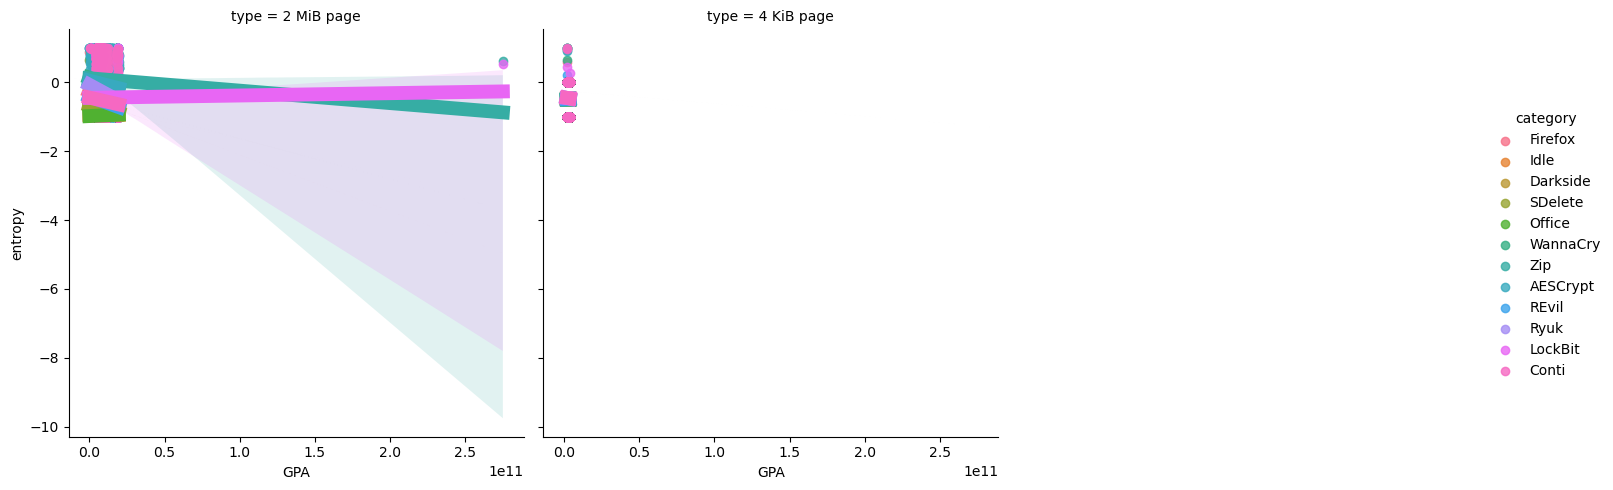

In [45]:
sns.lmplot(data=df_clean,
           x='GPA',
           y='entropy',
           col='type',
           hue='category',
           line_kws={'linewidth': 10},
           col_wrap=3)
plt.show()

`GPA` vs `entropy` vs `size` vs `category`

* The dual-panel trend plot examining GPA versus entropy relationships across different memory content sizes reveals a striking dichotomy in operational behavior patterns that fundamentally distinguishes metadata operations from actual content transfer activities within the RanSMAP dataset. The left panel, representing zero-byte operations, displays the characteristic tight clustering of all categories around the bimodal entropy distribution, with data points concentrated at -1.0 and 0.0 entropy values within the lower GPA range (below 0.5 × 10^11), demonstrating minimal trend variation and narrow confidence intervals across all twelve software categories. This consistent clustering pattern indicates that metadata operations exhibit homogeneous memory access behaviors regardless of whether the software is malicious ransomware or benign applications, suggesting that zero-byte operations primarily reflect standardized memory management activities such as page table updates, address translations, and system metadata handling that follow similar patterns across diverse software types. In dramatic contrast, the right panel representing 4096-byte operations reveals substantially different behavior with multiple categories exhibiting distinct trend lines, broader confidence intervals, and elevated entropy distributions that span from approximately -1.0 to +1.0 across the full GPA spectrum. The 4096-byte panel shows several categories displaying positive correlations where higher memory addresses correspond to increased entropy levels, while others maintain relatively flat trends, indicating that actual content transfer operations capture category-specific behavioral signatures that differentiate software types. Notably, the right panel demonstrates greater vertical spread in entropy values, with some operations reaching positive entropy levels not observed in the metadata operations, suggesting that bulk data transfers involve more diverse content types including compressed files, encrypted data, or complex application structures with inherent randomness characteristics. The substantial confidence interval variations across categories in the 4096-byte panel indicate significant behavioral differences in how various software types handle actual data content, with certain ransomware families potentially exhibiting distinct memory allocation and encryption patterns that could serve as discriminative features for classification models. This size-based behavioral dichotomy suggests that machine learning algorithms should treat metadata operations (zero-byte) and content operations (4096-byte) as fundamentally different feature spaces, with the latter providing more discriminative power for distinguishing between malicious and benign software based on their entropy-GPA relationship patterns during actual data processing activities.

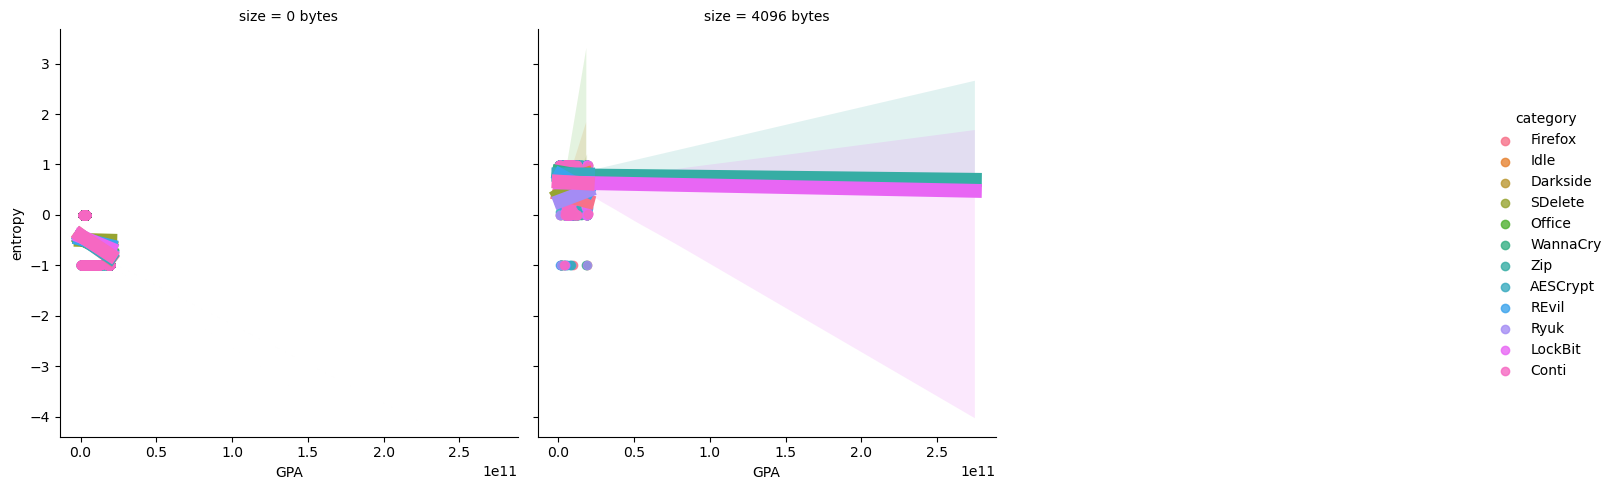

In [46]:
sns.lmplot(data=df_clean,
           x='GPA',
           y='entropy',
           col='size',
           hue='category',
           line_kws={'linewidth': 10},
           col_wrap=3)
plt.show()

### Preprocess

#### Extract numeric variables and create a clean copy.

In [47]:
df_features = df_clean.select_dtypes('number').\
              copy()

#### Standardize the numeric variables.

In [48]:
X_scaled = StandardScaler().\
           fit_transform(df_features)

In [49]:
X_scaled.shape

(1425904, 2)

## KMeans Analysis

### Identify and visualize the optimal number of clusters.

In [50]:
tots_within = []
K = range(1, 31)
for k in K:
    km = KMeans(n_clusters=k, 
                random_state=121, 
                n_init=5, 
                max_iter=100)
    km = km.fit(X_scaled)
    tots_within.append(km.inertia_)

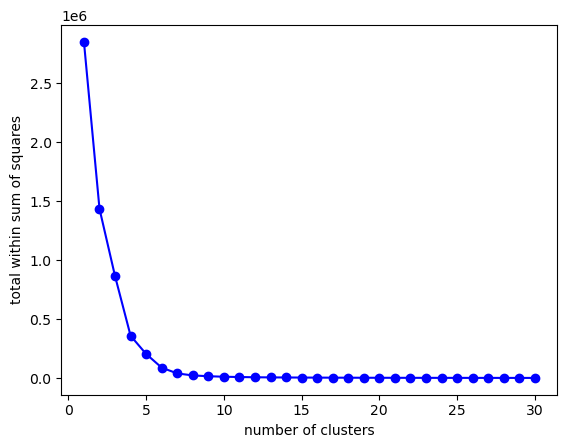

In [51]:
fig, ax = plt.subplots()
ax.plot(K, 
        tots_within, 
        'bo-')
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')
plt.show()

### Use the optimal number of clusters to create the KMeans object and review the number of oberservations per identified cluster.

In [52]:
clusters_4 = KMeans(n_clusters=4, 
                    random_state=121, 
                    n_init=5, 
                    max_iter=100).\
                    fit_predict(X_scaled)

In [53]:
df_clean_copy = df_clean.copy()

In [54]:
df_clean_copy['k4'] = pd.Series(clusters_4, index=df_clean_copy.index).astype('category')

In [55]:
df_clean_copy.k4.value_counts()

k4
1    394349
0    372722
2    337143
3    321690
Name: count, dtype: int64

`GPA` vs `entropy`, colored by `k4`, styled by `type`

* The K-means clustering visualization with four clusters reveals distinct patterns in the GPA-entropy feature space that effectively segregate memory access operations into meaningful behavioral groups within the RanSMAP dataset, demonstrating the natural clustering tendencies of memory operations based on their addressing and content randomness characteristics. Cluster 2 (green) dominates the visualization, forming a dense vertical band concentrated in the lower GPA range (below 0.5 × 10^11) and spanning the entire entropy spectrum from -1.0 to +1.0, representing the vast majority of memory operations that occur in standard memory regions with diverse entropy characteristics. This cluster primarily consists of 4 KiB page operations (indicated by X markers) with minimal 2 MiB page presence, suggesting it captures routine memory management activities including both structured data (near 0.0 entropy) and entropy-processed content (near -1.0 entropy). Cluster 0 (blue) appears as a smaller, concentrated group positioned at slightly elevated GPA values (around 0.2 × 10^11) with entropy values clustered near 0.0, exclusively comprising 4 KiB page operations and representing memory access patterns associated with structured, low-randomness content in specific memory regions. Cluster 3 (red) forms a distinctive pattern with two isolated points positioned at extremely high GPA values (around 2.5 × 10^11) and elevated entropy levels (0.5-0.6), exclusively involving 2 MiB large pages and representing specialized high-memory, high-entropy operations that likely correspond to performance-critical applications or specific malware behaviors utilizing large page architectures for bulk data processing. Cluster 1 (orange) occupies an intermediate position with moderate GPA values and mixed entropy characteristics, primarily consisting of 4 KiB pages with occasional 2 MiB page presence, suggesting a transitional behavioral category that bridges routine operations with more specialized memory access patterns. The clear separation between clusters, particularly the isolation of Cluster 3 in the high GPA-entropy region and the distinct positioning of Cluster 0, demonstrates that unsupervised clustering successfully identifies natural behavioral groupings in memory access patterns that could serve as valuable features for ransomware detection models, with each cluster potentially representing different operational phases or characteristics of malicious versus benign software execution.

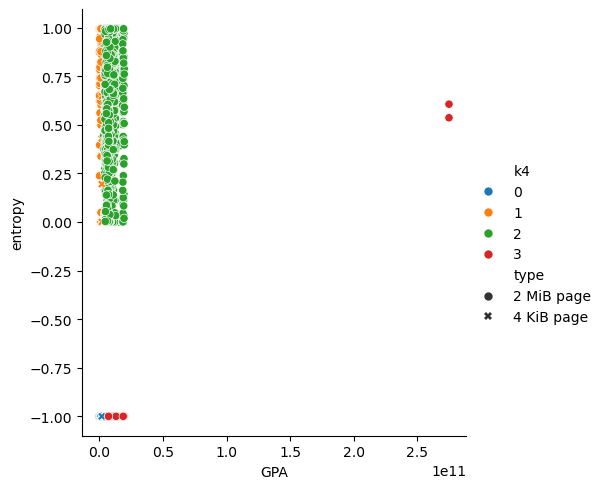

In [56]:
sns.relplot(data=df_clean_copy,
            x='GPA',
            y='entropy',
            hue='k4',
            style='type',
            size=None,  # you can use 'category' if you encode it numerically, or leave as None
            sizes=(20, 200))
plt.show()

`GPA` vs `entropy`, colored by `k4`, styled by `type`, col by `category`

* The category-specific K-means clustering visualization reveals distinct behavioral signatures and cluster distribution patterns that differentiate malware families from benign applications within the RanSMAP dataset, demonstrating how unsupervised clustering algorithms can capture category-specific memory access characteristics across the GPA-entropy feature space. Across the twelve category panels, Cluster 2 (green) consistently dominates most categories, forming the characteristic dense vertical distribution in lower GPA ranges with broad entropy coverage, but exhibits notable variations in density and distribution patterns between different software types. Benign applications such as Firefox, Idle, Office, and SDelete display relatively concentrated Cluster 2 formations with minimal outlier presence, suggesting consistent memory access patterns within standard operational parameters. In contrast, ransomware families like Darkside, WannaCry, REvil, AESCrypt, Ryuk, LockBit, and Conti show more varied cluster distributions with notable presence of other clusters, particularly Cluster 0 (blue) and Cluster 1 (orange), indicating more diverse memory access behaviors during malicious operations. Several categories exhibit unique cluster characteristics: Zip compression demonstrates a distinctive red point (Cluster 3) at extremely high GPA values around 2.5 × 10^11 with elevated entropy, exclusively involving 2 MiB pages, reflecting its specialized memory allocation strategy for bulk data processing. LockBit ransomware similarly shows a prominent red outlier at high GPA-entropy coordinates, suggesting systematic large-page utilization during encryption operations that distinguishes it from other ransomware families. The memory page type styling (circles for 2 MiB pages, X's for 4 KiB pages) reveals that most categories are overwhelmingly dominated by standard 4 KiB page operations, with 2 MiB large pages appearing as sparse outliers primarily in Cluster 3 formations across various categories. The clustering patterns demonstrate that while most software types share common memory management behaviors (represented by the ubiquitous Cluster 2), malware families exhibit more heterogeneous cluster distributions that could serve as discriminative features for classification algorithms. This category-specific cluster analysis suggests that ensemble learning approaches incorporating cluster membership as features could enhance ransomware detection by capturing the subtle behavioral differences in memory access patterns that distinguish malicious operations from benign application behaviors across the standardized memory management landscape.

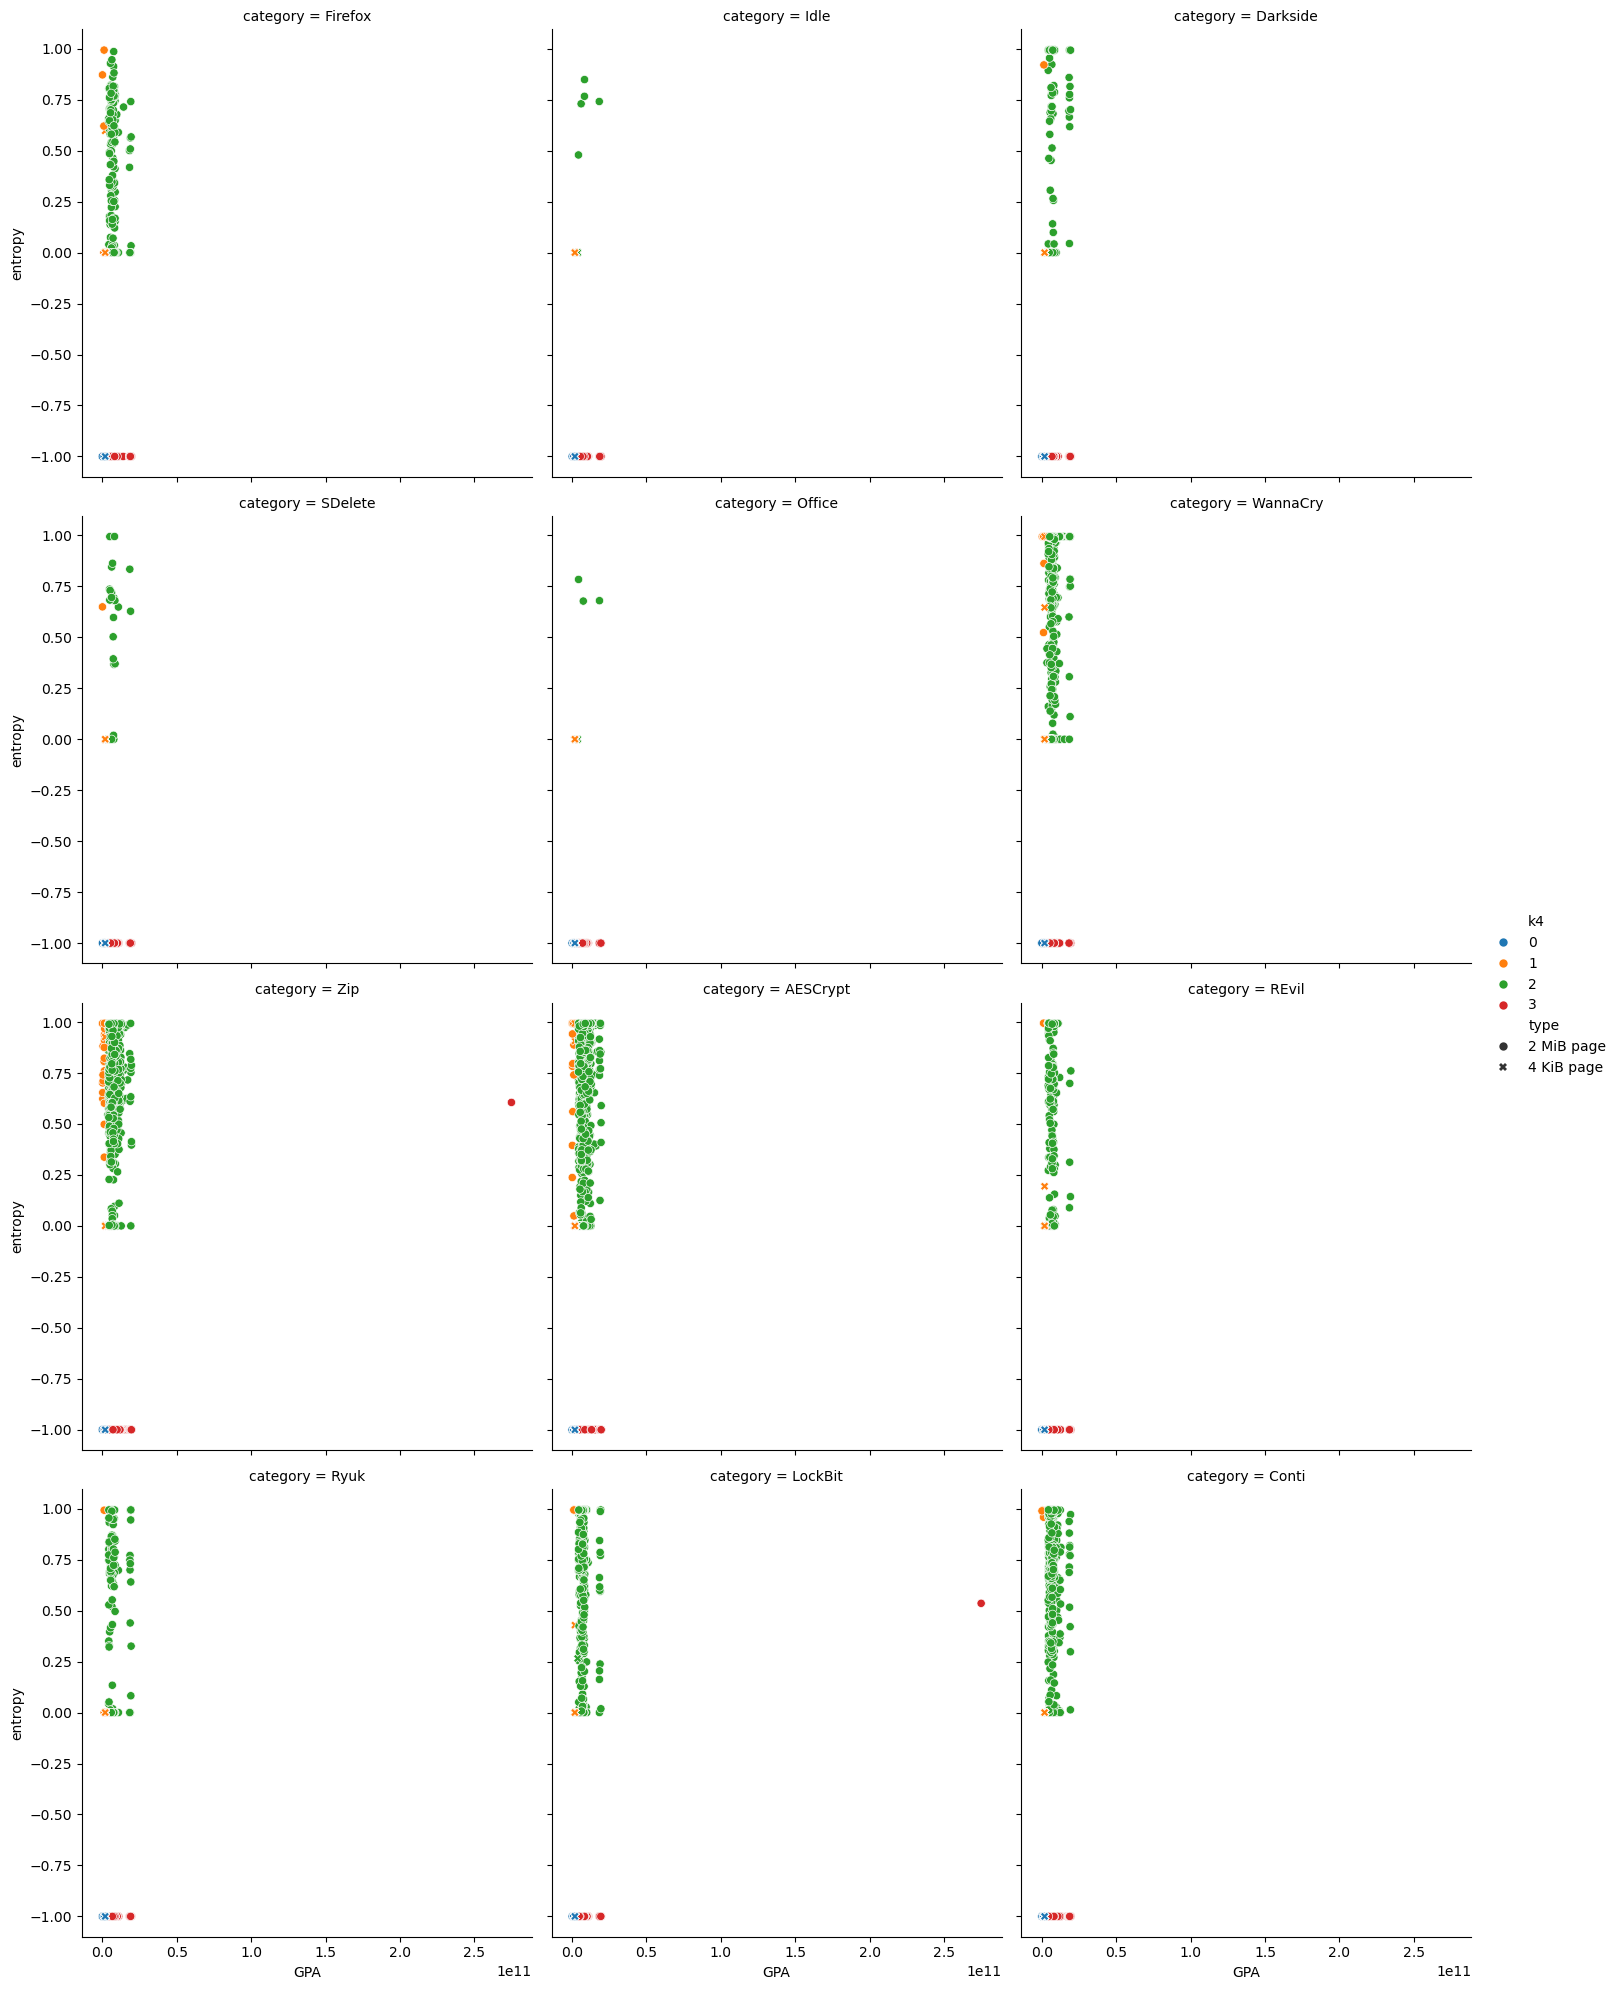

In [57]:
sns.relplot(data=df_clean_copy,
            x='GPA',
            y='entropy',
            hue='k4',
            style='type',
            col='category',
            col_wrap=3,
            sizes=(20, 200))
plt.show()

## PCA Analysis

In [58]:
pca = PCA(n_components=2).fit_transform(X_scaled)

In [59]:
pca.shape

(1425904, 2)

### Create a new DataFrame to examine the new variables that were created based on the original standardized features.

In [60]:
pca_df = pd.DataFrame(pca, 
                      columns=['pc01',
                               'pc02'])

In [61]:
pca_df.shape

(1425904, 2)

### Visualize the Cluster Results using PCA.

In [62]:
pca_df['k4'] = df_clean_copy['k4'].\
astype('category')

In [63]:
pca_df['size'] = df_clean_copy['size']

In [64]:
pca_df['type'] = df_clean_copy['type']

pc01 vs pc02, colored by `k4`, styled by `size`, and sized by `type`

* The Principal Component Analysis visualization with K-means clustering overlay reveals the dimensional reduction of the original GPA-entropy feature space into a two-component representation that preserves the essential clustering structure while providing enhanced interpretability of memory access behavioral patterns within the RanSMAP dataset. The first principal component (pc01) accounts for the primary variance direction, extending from approximately -25 to 175, while the second principal component (pc02) captures orthogonal variance spanning roughly 0 to 175, together forming a coordinate system that effectively separates the four identified clusters in the reduced dimensional space. Cluster 2 (green) dominates the lower-left quadrant with pc01 values ranging from -25 to approximately 25 and pc02 values concentrated near zero, forming a dense circular distribution that represents the majority of memory operations and corresponds to routine memory management activities with standard behavioral characteristics. Cluster 0 (blue), Cluster 1 (orange), and portions of Cluster 2 overlap in the central region around pc01 values of 0-25 and pc02 values of 0-15, indicating similar variance patterns in the principal component space despite their distinct clustering in the original GPA-entropy coordinates. The most striking feature is the extreme outlier position of Cluster 3 (red), represented by a single large X marker positioned at approximately pc01=175 and pc02=175, indicating maximum separation along both principal component axes and representing 4096-byte operations that exhibit fundamentally different variance characteristics from all other memory access patterns. The size styling effectively differentiates between memory page types, with the large circular markers representing 2 MiB pages appearing primarily as small dots in the lower clusters, while the distinctive large X marker represents 4 KiB pages associated with the extreme Cluster 3 outlier. The shape styling reveals that zero-byte operations (circles) dominate the clustered regions near the origin, while the single 4096-byte operation (X) occupies the extreme outlier position, demonstrating that actual content transfer operations possess fundamentally different principal component characteristics that distinguish them from metadata operations. This PCA representation suggests that the original two-dimensional GPA-entropy feature space contains sufficient discriminative information to separate memory access behaviors, with the extreme outlier position of content transfer operations indicating their potential value as high-impact features for ransomware classification models operating in the reduced dimensional space.

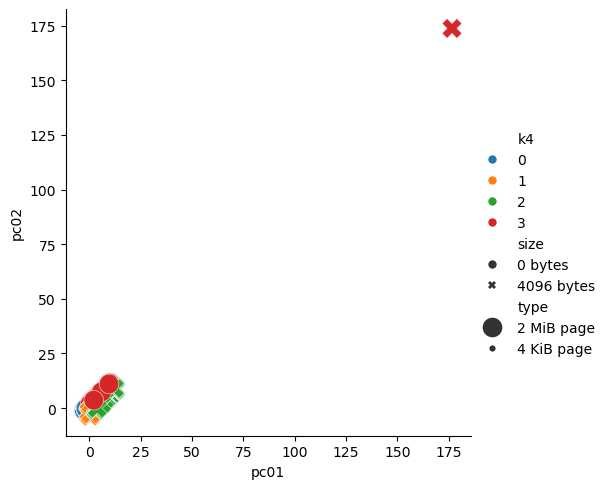

In [65]:
sns.relplot(data=pca_df, 
            x='pc01', 
            y='pc02', 
            hue='k4',
            style='size',
            size='type',
            sizes=(20, 200))
plt.show()

`category` vs `k4` clusters

* The cross-tabulation heatmap between malware categories and K-means clusters reveals distinct distributional patterns that illuminate how different software types exhibit characteristic memory access behaviors across the four identified behavioral clusters within the RanSMAP dataset. Cluster 1 emerges as the dominant behavioral pattern across all categories, consistently representing the largest proportion of operations for every software type, with notable concentrations in SDelete (87,986 operations), REvil (65,404 operations), and Conti (48,877 operations), demonstrating that this cluster captures fundamental memory management activities common to both malicious and benign software execution. Cluster 0 shows the second-highest overall activity with 372,722 total operations, exhibiting relatively balanced distribution across categories but with pronounced concentrations in SDelete (87,910 operations), REvil (63,042 operations), and Darkside (44,345 operations), suggesting this cluster represents another core memory access pattern that spans diverse software behaviors. Cluster 2 displays more varied category-specific patterns, with its 337,143 total operations showing notable peaks in specific categories like Darkside (37,015 operations), LockBit (49,444 operations), and WannaCry (34,870 operations), indicating specialized memory access behaviors that may be more characteristic of certain malware families' operational signatures. The most intriguing pattern emerges in Cluster 3, which represents the smallest behavioral group with only 321,690 total operations but shows distinctive category-specific concentrations, particularly elevated activity in WannaCry (35,555 operations), LockBit (43,368 operations), and Conti (37,221 operations), suggesting this cluster captures rare but potentially discriminative memory access patterns that could serve as malware-specific behavioral fingerprints. The marginal totals reveal the overall category prevalence within the dataset, with SDelete dominating at 279,124 operations, followed by REvil (228,317), LockBit (174,202), and Darkside (164,329), while smaller categories like Firefox (24,738), Office (25,068), and Idle (25,401) provide important benign baselines for comparison. This cross-tabulation demonstrates that while certain clusters represent universal memory management behaviors across all software types, specific cluster-category combinations exhibit elevated frequencies that could indicate characteristic behavioral signatures unique to particular malware families, providing valuable insights for developing targeted classification features that leverage these distributional differences for enhanced ransomware detection accuracy.

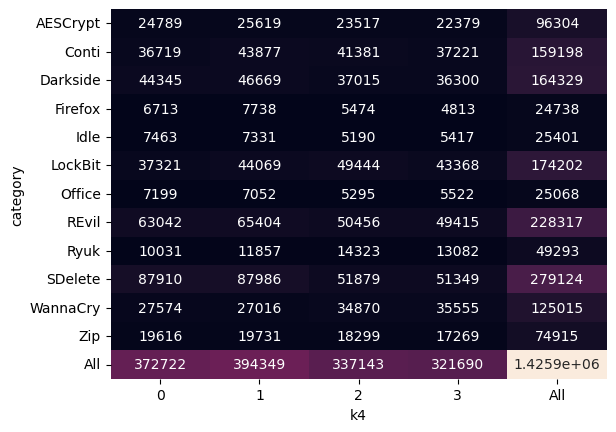

In [66]:
fig, ax = plt.subplots()
sns.heatmap(
    data=pd.crosstab(df_clean_copy['category'], 
    df_clean_copy['k4'], 
    margins=True),
    cbar=False,
    annot=True,
    annot_kws={"fontsize": 10},
    fmt='g',
    ax=ax
)
plt.show()

## Modeling

### Load the dataset.

In [67]:
df = pd.read_csv('mem_all_operations_sample.csv')

In [68]:
df.dtypes

UNIX_time_sec      int64
UNIX_time_ns       int64
GPA                int64
size               int64
entropy          float64
type               int64
category          object
dtype: object

### Create the binary `is_ransomware` variable.

In [69]:
benign_categories = ['AESCrypt', 'Zip', 'SDelete', 'Firefox', 'Office', 'Idle']
df['is_ransomware'] = df['category'].apply(lambda x: 0 if x in benign_categories else 1)

In [70]:
df.head()

,UNIX_time_sec,UNIX_time_ns,GPA,size,entropy,type,category,is_ransomware
0,1674094033,8577689,18608038176,0,-1.0,2,Firefox,0
1,1674093980,244086569,48161696,0,-1.0,2,Firefox,0
2,1674094013,490348749,1889674000,0,-1.0,4,Firefox,0
3,1674094062,202609873,1889674036,0,-1.0,4,Firefox,0
4,1674094010,6053928,1887699136,0,-1.0,4,Firefox,0


### Save the dataset.

In [71]:
df.to_csv('mem_all_operations_sample_w_ransomware_classifications.csv', index=False)

### Reload the dataset.

In [72]:
df = pd.read_csv('mem_all_operations_sample_w_ransomware_classifications.csv')

### Create feature and target variables.

In [73]:
X = df[['GPA', 'size', 'entropy', 'type']].copy()
# X['type'] = X['type'].astype('category').cat.codes
# X['size'] = X['size'].astype('category').cat.codes
y = df['is_ransomware']

### Determine if we need to standardize the dataset.

In [74]:
df[['GPA', 'size', 'entropy', 'type']].describe()

,GPA,size,entropy,type
count,1.425904e+06,1.425904e+06,1.425904e+06,1.425904e+06
mean,2.774001e+09,1.174879e+01,-4.849244e-01,3.986897e+00
std,1.098209e+09,2.190548e+02,5.036265e-01,1.613532e-01
min,2.252848e+06,0.000000e+00,-1.000000e+00,2.000000e+00
25%,1.889674e+09,0.000000e+00,-1.000000e+00,4.000000e+00
50%,1.890592e+09,0.000000e+00,-0.000000e+00,4.000000e+00
75%,3.744641e+09,0.000000e+00,0.000000e+00,4.000000e+00
max,2.748795e+11,4.096000e+03,9.955391e-01,4.000000e+00


### Train-Test model and split the dataset.

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    stratify=y,
                                                    test_size=0.25,
                                                    random_state=42)

### Standardize the features.

In [76]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Common functions for modeling.

In [77]:
def compute_metrics(name, y_test, y_preds):
  """
  Compute and display classification performance metrics for a model.
  
  This function calculates accuracy, precision, recall, and F1 score for binary 
  or multi-class classification predictions and prints them in a formatted manner.
  
  Parameters
  ----------
  name : str
    The name or description of the model being evaluated. Used for display purposes.
  y_test : array-like of shape (n_samples,)
    True labels for the test set. Should contain the actual class labels.
  y_preds : array-like of shape (n_samples,)
    Predicted labels from the model. Should contain the predicted class labels.
  
  Returns
  -------
  None
    This function does not return any values. It prints the computed metrics
    to the console in a formatted display.
  
  Notes
  -----
  - Precision, recall, and F1 score are calculated using 'weighted' averaging,
    which accounts for label imbalance by weighting metrics by support (number
    of true instances for each label).
  - For binary classification, weighted averaging will give the same result as
    macro averaging.
  - All metrics are displayed with 3 decimal places for consistency.
  
  Examples
  --------
  >>> from sklearn.metrics import accuracy_score
  >>> y_true = [0, 1, 1, 0, 1]
  >>> y_pred = [0, 1, 0, 0, 1]
  >>> compute_metrics("Test Model", y_true, y_pred)
  Test Model (test data): 
    o accuracy:           0.800
    o weighted precision: 0.800 
    o weighted recall:    0.800 
    o weighted F1 score:  0.800
  """
  
  accuracy  = accuracy_score(y_test, y_preds)
  precision = precision_score(y_test, y_preds, average='weighted')
  recall    = recall_score(y_test, y_preds, average='weighted')
  f1        = f1_score(y_test, y_preds, average='weighted')

  print(f'''{name} (test data): 
  o accuracy:           {accuracy:.3f}
  o weighted precision: {precision:.3f} 
  o weighted recall:    {recall:.3f} 
  o weighted F1 score:  {f1:.3f}
''')
  return  

### Ensemble Models

#### Voting Ensemble for Classification Model (Majority Vote)

In [78]:
# Define three different classifiers
clf1 = KNeighborsClassifier(n_neighbors=3)
clf2 = KNeighborsClassifier(n_neighbors=5)
clf3 = DecisionTreeClassifier(max_depth=4, random_state=42)

# Create a hard voting ensemble of these classifiers
voting_clf = VotingClassifier(estimators=[
    ('knn-3', clf1), ('knn-5', clf2), ('dt', clf3)
], voting='hard')

# Train individual models and the ensemble
for clf in (clf1, clf2, clf3, voting_clf):
    clf.fit(X_train_scaled, y_train)

# Evaluate quality on the test set - use scaled data for all models
for name, clf in [('KNN-3', clf1), ('KNN-5', clf2), ('DecisionTree', clf3), ('Ensemble', voting_clf)]:
    y_pred = clf.predict(X_test_scaled) 
    accuracy  = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
    recall    = recall_score(y_test, y_pred, average='weighted', zero_division=0)
    f1        = f1_score(y_test, y_pred, average='weighted', zero_division=0)
    print(f'{name:12} test -- accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, F1: {f1:.3f}')

KNN-3        test -- accuracy: 0.535, precision: 0.535, recall: 0.535, F1: 0.535
KNN-5        test -- accuracy: 0.591, precision: 0.550, recall: 0.591, F1: 0.554
DecisionTree test -- accuracy: 0.639, precision: 0.706, recall: 0.639, F1: 0.508
Ensemble     test -- accuracy: 0.592, precision: 0.549, recall: 0.592, F1: 0.552


#### Bagging for Classification Tasks Model

In [79]:
# Define base classifier
base_clf = DecisionTreeClassifier(random_state=0)

# Define bagging classifier
bag_clf = BaggingClassifier(estimator=base_clf, 
                            n_estimators=10,
                            bootstrap=True,
                            random_state=0)

# Fit both classifiers
base_clf.fit(X_train_scaled, y_train)
bag_clf.fit(X_train_scaled, y_train)

# Predict on test set
single_preds = base_clf.predict(X_test_scaled)
bag_preds = bag_clf.predict(X_test_scaled)

# Compute and print performance metrics
accuracy  = accuracy_score(y_test, single_preds)
precision = precision_score(y_test, single_preds)
recall    = recall_score(y_test, single_preds)
f1        = f1_score(y_test, single_preds)
name      = 'Single Decision Tree'
print(f"{name} (test data) -- accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, F1: {f1:.3f}")
accuracy  = accuracy_score(y_test, bag_preds)
precision = precision_score(y_test, bag_preds)
recall    = recall_score(y_test, bag_preds)
f1        = f1_score(y_test, bag_preds)
name      = 'Bagging (10 Trees)  '
print(f"{name} (test data) -- accuracy: {accuracy:.3f}, precision: {precision:.3f}, recall: {recall:.3f}, F1: {f1:.3f}")


Single Decision Tree (test data) -- accuracy: 0.638, precision: 0.637, recall: 0.995, F1: 0.776
Bagging (10 Trees)   (test data) -- accuracy: 0.639, precision: 0.637, recall: 0.994, F1: 0.776


#### Random Forest Model

In [80]:
# Train a single decision tree vs. a random forest
tree = DecisionTreeClassifier(random_state=42)
rf = RandomForestClassifier(n_estimators=100, random_state=42)

tree.fit(X_train_scaled, y_train)
rf.fit(X_train_scaled, y_train)

# Generate predictions
tree_preds = tree.predict(X_test_scaled)
rf_preds   = rf.predict(X_test_scaled)

# Compute and print performance metrics
compute_metrics('Single Decision Tree', y_test, tree_preds)
compute_metrics('Random Forest', y_test, rf_preds)

Single Decision Tree (test data): 
  o accuracy:           0.638
  o weighted precision: 0.680 
  o weighted recall:    0.638 
  o weighted F1 score:  0.510

Random Forest (test data): 
  o accuracy:           0.639
  o weighted precision: 0.681 
  o weighted recall:    0.639 
  o weighted F1 score:  0.511



#### Boosting Model

In [81]:
# Single weak learner (decision stump)
stump = DecisionTreeClassifier(max_depth=1,     # max tree depth = 1, to make a "stump"
                               random_state=42)

# Full tree, for comparison 
tree = DecisionTreeClassifier(random_state=42)  # no limit on max tree depth

# AdaBoost ensemble of 50 stumps
ada = AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1), 
                         n_estimators=50, 
                         learning_rate=1.0, 
                         random_state=0)

# Fit model to training data
stump.fit(X_train_scaled, y_train)
tree.fit(X_train_scaled, y_train)
ada.fit(X_train_scaled, y_train)

# Generate predictions
stump_preds = stump.predict(X_test_scaled)
tree_preds  = tree.predict(X_test_scaled)
ada_preds   = ada.predict(X_test_scaled)

# Compute and print performance metrics
compute_metrics('Single Stump', y_test, stump_preds)
compute_metrics('Full Decision Tree', y_test, tree_preds)
compute_metrics('AdaBoost (50 stumps)', y_test, ada_preds)

/opt/anaconda3/envs/prod/lib/python3.12/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/opt/anaconda3/envs/prod/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Single Stump (test data): 
  o accuracy:           0.631
  o weighted precision: 0.399 
  o weighted recall:    0.631 
  o weighted F1 score:  0.489

Full Decision Tree (test data): 
  o accuracy:           0.638
  o weighted precision: 0.680 
  o weighted recall:    0.638 
  o weighted F1 score:  0.510

AdaBoost (50 stumps) (test data): 
  o accuracy:           0.639
  o weighted precision: 0.675 
  o weighted recall:    0.639 
  o weighted F1 score:  0.512



#### Stacking Model

In [82]:
# Define base models
base_models = [
    ('Logistic Regression', LogisticRegression(max_iter=1000)),
    ('Decision Tree (depth=3)', DecisionTreeClassifier(max_depth=3, random_state=42)),
    ('KNN (K=5)', KNeighborsClassifier(n_neighbors=5))
]

# Define stacking ensemble with logistic regression meta-model
stack_clf = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression(), cv=5)

# Fit stacking model to training data
stack_clf.fit(X_train_scaled, y_train)
stack_preds = stack_clf.predict(X_test_scaled)

# Compute and print performance metrics
compute_metrics('Stacked', y_test, stack_preds)

# Evaluate each base model and the stacked model
for name, model in base_models:
    model.fit(X_train_scaled, y_train)
    y_preds = model.predict(X_test_scaled)
    compute_metrics(name, y_test, y_preds)

Stacked (test data): 
  o accuracy:           0.639
  o weighted precision: 0.699 
  o weighted recall:    0.639 
  o weighted F1 score:  0.509

Logistic Regression (test data): 
  o accuracy:           0.631
  o weighted precision: 0.578 
  o weighted recall:    0.631 
  o weighted F1 score:  0.492

Decision Tree (depth=3) (test data): 
  o accuracy:           0.639
  o weighted precision: 0.699 
  o weighted recall:    0.639 
  o weighted F1 score:  0.509

KNN (K=5) (test data): 
  o accuracy:           0.591
  o weighted precision: 0.550 
  o weighted recall:    0.591 
  o weighted F1 score:  0.554



## Model Persistence and Inference

### Save the bagging model and scaler.

In [83]:
# Save the trained bagging model and scaler
joblib.dump(bag_clf, 'bagging_ransomware_model.pkl')
joblib.dump(scaler, 'feature_scaler.pkl')

# Print confirmation messages with accuracy and F1 score
print("Bagging model saved as 'bagging_ransomware_model.pkl'")
print("Feature scaler saved as 'feature_scaler.pkl'")
print(f"Model accuracy on test set: {accuracy_score(y_test, bag_preds):.3f}")
print(f"Model F1 score on test set: {f1_score(y_test, bag_preds):.3f}")

Bagging model saved as 'bagging_ransomware_model.pkl'
Feature scaler saved as 'feature_scaler.pkl'
Model accuracy on test set: 0.639
Model F1 score on test set: 0.776


### Load the saved model and scaler.

In [84]:
# Load the saved model and scaler
loaded_model = joblib.load('bagging_ransomware_model.pkl')
loaded_scaler = joblib.load('feature_scaler.pkl')

# Verify the loaded model and scaler
print("Model and scaler loaded successfully!")
print(f"Loaded model type: {type(loaded_model)}")
print(f"Number of estimators in the loaded bagging model: {loaded_model.n_estimators}")
print(f"Base estimator: {type(loaded_model.estimator)}")

# Verify the loaded model works by predicting on test set
loaded_predictions = loaded_model.predict(X_test_scaled)
loaded_accuracy = accuracy_score(y_test, loaded_predictions)
print(f"Loaded model accuracy on test set: {loaded_accuracy:.3f}")

Model and scaler loaded successfully!
Loaded model type: <class 'sklearn.ensemble._bagging.BaggingClassifier'>
Number of estimators in the loaded bagging model: 10
Base estimator: <class 'sklearn.tree._classes.DecisionTreeClassifier'>
Loaded model accuracy on test set: 0.639


### Create inference function for easy prediction.

In [85]:
def predict_ransomware(gpa, size, entropy, memory_type, model_path='bagging_ransomware_model.pkl', scaler_path='feature_scaler.pkl'):
    """
    Predict whether memory access patterns indicate ransomware activity.
    
    Parameters:
    -----------
    gpa : int or hex
        Guest Physical Address of accessed memory page
    size : int  
        Size of memory contents in bytes
    entropy : float
        Normalized Shannon entropy (0-1)
    memory_type : int
        Access type: 4 (4 KiB page), 2 (2 MiB page), 1 (1 GiB page)
    model_path : str
        Path to saved model file
    scaler_path : str
        Path to saved scaler file
    
    Returns:
    --------
    dict : Prediction results with classification, confidence, and probabilities
    """
    
    # Load model and scaler
    model = joblib.load(model_path)
    scaler = joblib.load(scaler_path)
    
    # Create DataFrame with input features
    input_data = pd.DataFrame({
        'GPA': [gpa],
        'size': [size], 
        'entropy': [entropy],
        'type': [memory_type]
    })
    
    # Scale the input data
    input_scaled = scaler.transform(input_data)
    
    # Make prediction
    prediction = model.predict(input_scaled)[0]
    probabilities = model.predict_proba(input_scaled)[0]
    
    # Format results
    classification = "RANSOMWARE" if prediction == 1 else "BENIGN"
    confidence = max(probabilities) * 100
    
    # Convert memory type to readable format
    type_mapping = {4: '4 KiB page', 2: '2 MiB page', 1: '1 GiB page'}
    type_readable = type_mapping.get(memory_type, f'Unknown ({memory_type})')
    
    return {
        'classification': classification,
        'confidence': confidence,
        'probabilities': {
            'benign': probabilities[0],
            'ransomware': probabilities[1]
        },
        'input_features': {
            'GPA': f"{gpa:#x}" if isinstance(gpa, int) else gpa,
            'size': f"{size} bytes",
            'entropy': f"{entropy:.3f}",
            'type': type_readable
        }
    }

### Inference on new data.

In [86]:
# Test the inference function with different examples
print("Testing the inference function:")
print("=" * 60)

# Test case 1: High entropy, typical ransomware pattern
result1 = predict_ransomware(gpa=0x80000000, size=4096, entropy=0.92, memory_type=4)
print("Test 1 - High entropy pattern:")
print(f"  Input: GPA={result1['input_features']['GPA']}, Size={result1['input_features']['size']}, Entropy={result1['input_features']['entropy']}, Type={result1['input_features']['type']}")
print(f"  Prediction: {result1['classification']} (Confidence: {result1['confidence']:.1f}%)")
print(f"  Probabilities: Benign={result1['probabilities']['benign']:.3f}, Ransomware={result1['probabilities']['ransomware']:.3f}")
print()

# Test case 2: Low entropy, typical benign pattern  
result2 = predict_ransomware(gpa=0x20000000, size=0, entropy=0.12, memory_type=4)
print("Test 2 - Low entropy pattern:")
print(f"  Input: GPA={result2['input_features']['GPA']}, Size={result2['input_features']['size']}, Entropy={result2['input_features']['entropy']}, Type={result2['input_features']['type']}")
print(f"  Prediction: {result2['classification']} (Confidence: {result2['confidence']:.1f}%)")
print(f"  Probabilities: Benign={result2['probabilities']['benign']:.3f}, Ransomware={result2['probabilities']['ransomware']:.3f}")
print()

# Test case 3: Edge case with 2 MiB page
result3 = predict_ransomware(gpa=0x60000000, size=4096, entropy=0.75, memory_type=2)
print("Test 3 - 2 MiB page pattern:")
print(f"  Input: GPA={result3['input_features']['GPA']}, Size={result3['input_features']['size']}, Entropy={result3['input_features']['entropy']}, Type={result3['input_features']['type']}")
print(f"  Prediction: {result3['classification']} (Confidence: {result3['confidence']:.1f}%)")
print(f"  Probabilities: Benign={result3['probabilities']['benign']:.3f}, Ransomware={result3['probabilities']['ransomware']:.3f}")

Testing the inference function:
Test 1 - High entropy pattern:
  Input: GPA=0x80000000, Size=4096 bytes, Entropy=0.920, Type=4 KiB page
  Prediction: BENIGN (Confidence: 67.9%)
  Probabilities: Benign=0.679, Ransomware=0.321

Test 2 - Low entropy pattern:
  Input: GPA=0x20000000, Size=0 bytes, Entropy=0.120, Type=4 KiB page
  Prediction: BENIGN (Confidence: 80.0%)
  Probabilities: Benign=0.800, Ransomware=0.200

Test 3 - 2 MiB page pattern:
  Input: GPA=0x60000000, Size=4096 bytes, Entropy=0.750, Type=2 MiB page
  Prediction: BENIGN (Confidence: 90.0%)
  Probabilities: Benign=0.900, Ransomware=0.100
